In [46]:
import xarray as xr
import numpy as np
import scipy.interpolate as interp
import pandas as pd

import numpy as np
import scipy.stats as stats

import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


import matplotlib.pyplot as plt

In [48]:
RSEED = 50

### Import ing the data

In [2]:
df_main= pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col=0)
df_main.columns

Index(['rgiid', 'x', 'y', 'Surge', 'Area', 'Slope', 'TermType', 'Name', 'bed',
       'thickness', 'surface_elevation', 'ELA', 'beta', 'cmb',
       'width_centerline', 'Runoff'],
      dtype='object')

In [3]:
df_main.drop(df_main[df_main['Surge']==9].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==1].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==2].index, inplace = True)
df = df_main
df.dropna(how='any', inplace=True)

In [4]:
df['Surge'] = df['Surge'].replace({3: 1})
df = df.loc[df['Surge'].isin([0, 1])].copy()

In [5]:
def get_slope(data, n_windows):
    gb = data.groupby(data.index // (data.shape[0]/n_windows))
    start = gb.head(1)
    end = gb.tail(1)
#     thick = abs(start.thickness.values - end.thickness.values)
    thick_mean = (start.thickness.values + end.thickness.values)/2
    width_mean = (start.width_centerline.values + end.width_centerline.values)/2
    ELA_mean = (start.ELA.values + end.ELA.values)/2
    CMB_mean = (start.cmb.values + end.cmb.values)/2
    beta_mean = (start.beta.values + end.beta.values)/2
    runoff_mean = (start.Runoff.values + end.Runoff.values)/2
    
    
    Z_min = gb.surface_elevation.min()
    Z_max = gb.surface_elevation.max()
    Z_mean = gb.surface_elevation.mean()
    
#     bed = end.bed.values - start.bed.values
    bed = start.bed.values - end.bed.values
    surf = start.surface_elevation.values - end.surface_elevation.values
    
    window_length = np.sqrt((start.x.values - end.x.values)**2 + (start.y.values - end.y.values)**2)
#     if window_length.min() == 0:
#         print(start.x.values, end.x.values, start.y.values, end.y.values, window_length)
#         print(start.rgiid.unique())
#     bed_slope = np.arctan(thick/window_length)
    bed_slope = np.arctan(bed/window_length)
    surf_slope = np.arctan(surf/window_length)
    
    print(data.rgiid.unique()[0], surf_slope.shape, surf_slope.shape)
    
    return {
        'window_length':window_length
        , 'bed_slope':bed_slope
        , 'thick_mean':thick_mean
        , 'surf_slope':surf_slope
        , 'width_mean': width_mean
        , 'ELA_mean': ELA_mean
        , 'CMB_mean': CMB_mean
        , 'beta_mean': beta_mean
        , 'runoff_mean': runoff_mean
        , 'Z_min': Z_min
        , 'Z_max': Z_max
        , 'Z_mean': Z_mean
        , 'window_id':np.arange(0, surf_slope.shape[0], 1)
    }


In [41]:
# sloped = df.groupby('rgiid').apply(get_slope)

number_of_windows = np.arange(1, 51, 1)

rocs = []
AUC=[]

for w in number_of_windows:

    sloped = df.groupby('rgiid').apply(lambda x: get_slope(x, w))

    slope_df = pd.DataFrame()

    for s in sloped.index:
        sdf = pd.DataFrame(sloped[s])
        sdf['rgiid'] = (s,)*sdf.shape[0]
        slope_df = pd.concat([slope_df, sdf])

    glacstats_df = df[['rgiid', 'Surge', 'Area', 'Slope', 'TermType', 'Name', 'bed',
       'thickness', 'surface_elevation', 'cmb', 'width_centerline', 'Runoff']].drop_duplicates()

    analysis_df = slope_df.merge(glacstats_df)
    analysis_df.dropna(subset=['thick_mean', 'bed_slope'], inplace=True)
    
    th = analysis_df.pivot_table(index='rgiid', columns='window_id', values='thick_mean')
    th.columns = ['thick_w'+str(t) for t in th.columns]

    wl = analysis_df.pivot_table(index='rgiid', columns='window_id', values='window_length')
    wl.columns = ['windowlength_w'+str(t) for t in wl.columns]

    bs = analysis_df.pivot_table(index='rgiid', columns='window_id', values='bed_slope')
    bs.columns = ['bedslope_w'+str(t) for t in bs.columns]

    ss = analysis_df.pivot_table(index='rgiid', columns='window_id', values='surf_slope')
    ss.columns = ['surfslope_w'+str(t) for t in ss.columns]
    
    wm = analysis_df.pivot_table(index='rgiid', columns='window_id', values='width_mean')
    wm.columns = ['width_w'+str(t) for t in wm.columns]
    
    cmb = analysis_df.pivot_table(index='rgiid', columns='window_id', values='CMB_mean')
    cmb.columns = ['CMB_w'+str(t) for t in cmb.columns]
    
    rs = analysis_df.pivot_table(index='rgiid', columns='window_id', values='runoff_mean')
    rs.columns = ['runoff_w'+str(t) for t in rs.columns]
    
    zmin = analysis_df.pivot_table(index='rgiid', columns='window_id', values='Z_min')
    zmin.columns = ['Zmin_w'+str(t) for t in zmin.columns]
    
    zmax = analysis_df.pivot_table(index='rgiid', columns='window_id', values='Z_max')
    zmax.columns = ['Zmax_w'+str(t) for t in zmax.columns]
    
    zmean= analysis_df.pivot_table(index='rgiid', columns='window_id', values='Z_mean')
    zmean.columns = ['Zmean_w'+str(t) for t in zmean.columns]

    # an_df = analysis_df[['rgiid', 'Name', 'surgetype', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax']].drop_duplicates().set_index('rgiid')
    an_df = analysis_df[['rgiid', 'Surge', 'Area', 'TermType']].drop_duplicates().set_index('rgiid')

    statmodel_df = an_df.join(th).join(wl).join(bs).join(ss).join(wm).join(cmb).join(rs).join(zmin).join(zmax).join(zmean).copy()
    
    columns_for_modeling = statmodel_df.columns

    x_train, x_test, y_train, y_test = train_test_split(statmodel_df[columns_for_modeling[1:]], statmodel_df[columns_for_modeling[0]], random_state=42)
    dmatrix_train = xgboost.DMatrix(x_train, label=y_train)
    dmatrix_test = xgboost.DMatrix(x_test, label=y_test)

    params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.3}

    xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

    params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.3}

    xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)
    
    predictions = xgb.predict(dmatrix_test)
    rocs.append(metrics.roc_curve(y_true=y_test, y_score=predictions))
    
    AUC.append(metrics.roc_auc_score(y_true=y_test, y_score=predictions))
    
    print('window size =', w, 'AUC =', metrics.roc_auc_score(y_true=y_test, y_score=predictions))

RGI60-07.00006 (2,) (2,)
RGI60-07.00008 (2,) (2,)
RGI60-07.00010 (2,) (2,)
RGI60-07.00024 (2,) (2,)
RGI60-07.00025 (2,) (2,)
RGI60-07.00026 (2,) (2,)
RGI60-07.00028 (2,) (2,)
RGI60-07.00029 (2,) (2,)
RGI60-07.00030 (2,) (2,)
RGI60-07.00031 (2,) (2,)
RGI60-07.00032 (2,) (2,)
RGI60-07.00035 (2,) (2,)
RGI60-07.00036 (2,) (2,)
RGI60-07.00037 (2,) (2,)
RGI60-07.00040 (2,) (2,)
RGI60-07.00041 (2,) (2,)
RGI60-07.00042 (2,) (2,)
RGI60-07.00043 (2,) (2,)
RGI60-07.00044 (2,) (2,)
RGI60-07.00045 (2,) (2,)
RGI60-07.00049 (2,) (2,)
RGI60-07.00052 (2,) (2,)
RGI60-07.00060 (2,) (2,)
RGI60-07.00061 (2,) (2,)
RGI60-07.00062 (2,) (2,)
RGI60-07.00063 (2,) (2,)
RGI60-07.00064 (2,) (2,)
RGI60-07.00065 (2,) (2,)
RGI60-07.00066 (2,) (2,)
RGI60-07.00068 (2,) (2,)
RGI60-07.00069 (2,) (2,)
RGI60-07.00070 (2,) (2,)
RGI60-07.00071 (2,) (2,)
RGI60-07.00072 (2,) (2,)
RGI60-07.00073 (2,) (2,)
RGI60-07.00074 (2,) (2,)
RGI60-07.00075 (2,) (2,)
RGI60-07.00076 (2,) (2,)
RGI60-07.00077 (2,) (2,)
RGI60-07.00094 (2,) (2,)


<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00108 (2,) (2,)
RGI60-07.00111 (2,) (2,)
RGI60-07.00113 (2,) (2,)
RGI60-07.00118 (2,) (2,)
RGI60-07.00124 (2,) (2,)
RGI60-07.00126 (2,) (2,)
RGI60-07.00128 (2,) (2,)
RGI60-07.00130 (2,) (2,)
RGI60-07.00134 (2,) (2,)
RGI60-07.00135 (2,) (2,)
RGI60-07.00140 (2,) (2,)
RGI60-07.00142 (2,) (2,)
RGI60-07.00146 (2,) (2,)
RGI60-07.00147 (2,) (2,)
RGI60-07.00150 (2,) (2,)
RGI60-07.00151 (2,) (2,)
RGI60-07.00153 (2,) (2,)
RGI60-07.00154 (2,) (2,)
RGI60-07.00157 (2,) (2,)
RGI60-07.00159 (2,) (2,)
RGI60-07.00160 (2,) (2,)
RGI60-07.00161 (2,) (2,)
RGI60-07.00163 (2,) (2,)
RGI60-07.00164 (2,) (2,)
RGI60-07.00165 (2,) (2,)
RGI60-07.00166 (2,) (2,)
RGI60-07.00168 (2,) (2,)
RGI60-07.00169 (2,) (2,)
RGI60-07.00173 (2,) (2,)
RGI60-07.00176 (2,) (2,)
RGI60-07.00177 (2,) (2,)
RGI60-07.00178 (2,) (2,)
RGI60-07.00180 (2,) (2,)
RGI60-07.00184 (2,) (2,)
RGI60-07.00193 (2,) (2,)
RGI60-07.00195 (2,) (2,)
RGI60-07.00196 (2,) (2,)
RGI60-07.00197 (2,) (2,)
RGI60-07.00198 (2,) (2,)
RGI60-07.00203 (2,) (2,)


<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00113 (3,) (3,)
RGI60-07.00118 (3,) (3,)
RGI60-07.00124 (3,) (3,)
RGI60-07.00126 (3,) (3,)
RGI60-07.00128 (3,) (3,)
RGI60-07.00130 (3,) (3,)
RGI60-07.00134 (3,) (3,)
RGI60-07.00135 (3,) (3,)
RGI60-07.00140 (3,) (3,)
RGI60-07.00142 (3,) (3,)
RGI60-07.00146 (3,) (3,)
RGI60-07.00147 (3,) (3,)
RGI60-07.00150 (3,) (3,)
RGI60-07.00151 (3,) (3,)
RGI60-07.00153 (3,) (3,)
RGI60-07.00154 (3,) (3,)
RGI60-07.00157 (3,) (3,)
RGI60-07.00159 (3,) (3,)
RGI60-07.00160 (3,) (3,)
RGI60-07.00161 (3,) (3,)
RGI60-07.00163 (3,) (3,)
RGI60-07.00164 (3,) (3,)
RGI60-07.00165 (3,) (3,)
RGI60-07.00166 (3,) (3,)
RGI60-07.00168 (3,) (3,)
RGI60-07.00169 (3,) (3,)
RGI60-07.00173 (3,) (3,)
RGI60-07.00176 (2,) (2,)
RGI60-07.00177 (3,) (3,)
RGI60-07.00178 (3,) (3,)
RGI60-07.00180 (3,) (3,)
RGI60-07.00184 (3,) (3,)
RGI60-07.00193 (3,) (3,)
RGI60-07.00195 (3,) (3,)
RGI60-07.00196 (3,) (3,)
RGI60-07.00197 (3,) (3,)
RGI60-07.00198 (3,) (3,)
RGI60-07.00203 (3,) (3,)
RGI60-07.00204 (3,) (3,)
RGI60-07.00205 (2,) (2,)


<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00128 (4,) (4,)
RGI60-07.00130 (4,) (4,)
RGI60-07.00134 (4,) (4,)
RGI60-07.00135 (4,) (4,)
RGI60-07.00140 (4,) (4,)
RGI60-07.00142 (4,) (4,)
RGI60-07.00146 (4,) (4,)
RGI60-07.00147 (4,) (4,)
RGI60-07.00150 (4,) (4,)
RGI60-07.00151 (4,) (4,)
RGI60-07.00153 (4,) (4,)
RGI60-07.00154 (4,) (4,)
RGI60-07.00157 (4,) (4,)
RGI60-07.00159 (4,) (4,)
RGI60-07.00160 (4,) (4,)
RGI60-07.00161 (4,) (4,)
RGI60-07.00163 (4,) (4,)
RGI60-07.00164 (4,) (4,)
RGI60-07.00165 (4,) (4,)
RGI60-07.00166 (3,) (3,)
RGI60-07.00168 (4,) (4,)
RGI60-07.00169 (4,) (4,)
RGI60-07.00173 (4,) (4,)
RGI60-07.00176 (4,) (4,)
RGI60-07.00177 (4,) (4,)
RGI60-07.00178 (4,) (4,)
RGI60-07.00180 (4,) (4,)
RGI60-07.00184 (4,) (4,)
RGI60-07.00193 (4,) (4,)
RGI60-07.00195 (4,) (4,)
RGI60-07.00196 (4,) (4,)
RGI60-07.00197 (4,) (4,)
RGI60-07.00198 (4,) (4,)
RGI60-07.00203 (4,) (4,)
RGI60-07.00204 (4,) (4,)
RGI60-07.00205 (4,) (4,)
RGI60-07.00208 (4,) (4,)
RGI60-07.00214 (4,) (4,)
RGI60-07.00219 (4,) (4,)
RGI60-07.00220 (4,) (4,)


<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00098 (5,) (5,)
RGI60-07.00102 (5,) (5,)
RGI60-07.00104 (5,) (5,)
RGI60-07.00106 (5,) (5,)
RGI60-07.00108 (5,) (5,)
RGI60-07.00111 (5,) (5,)
RGI60-07.00113 (5,) (5,)
RGI60-07.00118 (5,) (5,)
RGI60-07.00124 (5,) (5,)
RGI60-07.00126 (5,) (5,)
RGI60-07.00128 (5,) (5,)
RGI60-07.00130 (5,) (5,)
RGI60-07.00134 (5,) (5,)
RGI60-07.00135 (5,) (5,)
RGI60-07.00140 (5,) (5,)
RGI60-07.00142 (5,) (5,)
RGI60-07.00146 (5,) (5,)
RGI60-07.00147 (5,) (5,)
RGI60-07.00150 (5,) (5,)
RGI60-07.00151 (5,) (5,)
RGI60-07.00153 (5,) (5,)
RGI60-07.00154 (5,) (5,)
RGI60-07.00157 (5,) (5,)
RGI60-07.00159 (5,) (5,)
RGI60-07.00160 (5,) (5,)
RGI60-07.00161 (5,) (5,)
RGI60-07.00163 (5,) (5,)
RGI60-07.00164 (5,) (5,)
RGI60-07.00165 (5,) (5,)
RGI60-07.00166 (5,) (5,)
RGI60-07.00168 (5,) (5,)
RGI60-07.00169 (5,) (5,)
RGI60-07.00173 (5,) (5,)
RGI60-07.00176 (4,) (4,)
RGI60-07.00177 (5,) (5,)
RGI60-07.00178 (5,) (5,)
RGI60-07.00180 (5,) (5,)
RGI60-07.00184 (5,) (5,)
RGI60-07.00193 (5,) (5,)
RGI60-07.00195 (5,) (5,)


<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00130 (6,) (6,)
RGI60-07.00134 (6,) (6,)
RGI60-07.00135 (6,) (6,)
RGI60-07.00140 (6,) (6,)
RGI60-07.00142 (7,) (7,)
RGI60-07.00146 (6,) (6,)
RGI60-07.00147 (6,) (6,)
RGI60-07.00150 (6,) (6,)
RGI60-07.00151 (6,) (6,)
RGI60-07.00153 (5,) (5,)
RGI60-07.00154 (6,) (6,)
RGI60-07.00157 (5,) (5,)
RGI60-07.00159 (6,) (6,)
RGI60-07.00160 (6,) (6,)
RGI60-07.00161 (6,) (6,)
RGI60-07.00163 (6,) (6,)
RGI60-07.00164 (6,) (6,)
RGI60-07.00165 (6,) (6,)
RGI60-07.00166 (6,) (6,)
RGI60-07.00168 (5,) (5,)
RGI60-07.00169 (6,) (6,)
RGI60-07.00173 (6,) (6,)
RGI60-07.00176 (6,) (6,)
RGI60-07.00177 (6,) (6,)
RGI60-07.00178 (6,) (6,)
RGI60-07.00180 (6,) (6,)
RGI60-07.00184 (6,) (6,)
RGI60-07.00193 (6,) (6,)
RGI60-07.00195 (6,) (6,)
RGI60-07.00196 (6,) (6,)
RGI60-07.00197 (6,) (6,)
RGI60-07.00198 (6,) (6,)
RGI60-07.00203 (6,) (6,)
RGI60-07.00204 (6,) (6,)
RGI60-07.00205 (6,) (6,)
RGI60-07.00208 (6,) (6,)
RGI60-07.00214 (6,) (6,)
RGI60-07.00219 (6,) (6,)
RGI60-07.00220 (6,) (6,)
RGI60-07.00221 (6,) (6,)


<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00077 (7,) (7,)
RGI60-07.00094 (7,) (7,)
RGI60-07.00098 (7,) (7,)
RGI60-07.00102 (6,) (6,)
RGI60-07.00104 (7,) (7,)
RGI60-07.00106 (7,) (7,)
RGI60-07.00108 (7,) (7,)
RGI60-07.00111 (7,) (7,)
RGI60-07.00113 (7,) (7,)
RGI60-07.00118 (7,) (7,)
RGI60-07.00124 (7,) (7,)
RGI60-07.00126 (7,) (7,)
RGI60-07.00128 (7,) (7,)
RGI60-07.00130 (7,) (7,)
RGI60-07.00134 (7,) (7,)
RGI60-07.00135 (7,) (7,)
RGI60-07.00140 (7,) (7,)
RGI60-07.00142 (7,) (7,)
RGI60-07.00146 (7,) (7,)
RGI60-07.00147 (7,) (7,)
RGI60-07.00150 (8,) (8,)
RGI60-07.00151 (7,) (7,)
RGI60-07.00153 (7,) (7,)
RGI60-07.00154 (7,) (7,)
RGI60-07.00157 (7,) (7,)
RGI60-07.00159 (7,) (7,)
RGI60-07.00160 (7,) (7,)
RGI60-07.00161 (7,) (7,)
RGI60-07.00163 (7,) (7,)
RGI60-07.00164 (7,) (7,)
RGI60-07.00165 (7,) (7,)
RGI60-07.00166 (6,) (6,)
RGI60-07.00168 (7,) (7,)
RGI60-07.00169 (7,) (7,)
RGI60-07.00173 (7,) (7,)
RGI60-07.00176 (6,) (6,)
RGI60-07.00177 (7,) (7,)
RGI60-07.00178 (7,) (7,)
RGI60-07.00180 (7,) (7,)
RGI60-07.00184 (7,) (7,)


<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00130 (8,) (8,)
RGI60-07.00134 (8,) (8,)
RGI60-07.00135 (8,) (8,)
RGI60-07.00140 (8,) (8,)
RGI60-07.00142 (8,) (8,)
RGI60-07.00146 (7,) (7,)
RGI60-07.00147 (8,) (8,)
RGI60-07.00150 (9,) (9,)
RGI60-07.00151 (8,) (8,)
RGI60-07.00153 (8,) (8,)
RGI60-07.00154 (8,) (8,)
RGI60-07.00157 (8,) (8,)
RGI60-07.00159 (8,) (8,)
RGI60-07.00160 (8,) (8,)
RGI60-07.00161 (8,) (8,)
RGI60-07.00163 (7,) (7,)
RGI60-07.00164 (8,) (8,)
RGI60-07.00165 (7,) (7,)
RGI60-07.00166 (8,) (8,)
RGI60-07.00168 (8,) (8,)
RGI60-07.00169 (8,) (8,)
RGI60-07.00173 (8,) (8,)
RGI60-07.00176 (8,) (8,)
RGI60-07.00177 (8,) (8,)
RGI60-07.00178 (8,) (8,)
RGI60-07.00180 (8,) (8,)
RGI60-07.00184 (8,) (8,)
RGI60-07.00193 (8,) (8,)
RGI60-07.00195 (8,) (8,)
RGI60-07.00196 (8,) (8,)
RGI60-07.00197 (8,) (8,)
RGI60-07.00198 (8,) (8,)
RGI60-07.00203 (8,) (8,)
RGI60-07.00204 (8,) (8,)
RGI60-07.00205 (8,) (8,)
RGI60-07.00208 (7,) (7,)
RGI60-07.00214 (8,) (8,)
RGI60-07.00219 (8,) (8,)
RGI60-07.00220 (8,) (8,)
RGI60-07.00221 (8,) (8,)


<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00126 (9,) (9,)
RGI60-07.00128 (9,) (9,)
RGI60-07.00130 (9,) (9,)
RGI60-07.00134 (9,) (9,)
RGI60-07.00135 (9,) (9,)
RGI60-07.00140 (9,) (9,)
RGI60-07.00142 (10,) (10,)
RGI60-07.00146 (9,) (9,)
RGI60-07.00147 (9,) (9,)
RGI60-07.00150 (9,) (9,)
RGI60-07.00151 (8,) (8,)
RGI60-07.00153 (9,) (9,)
RGI60-07.00154 (9,) (9,)
RGI60-07.00157 (9,) (9,)
RGI60-07.00159 (9,) (9,)
RGI60-07.00160 (9,) (9,)
RGI60-07.00161 (9,) (9,)
RGI60-07.00163 (9,) (9,)
RGI60-07.00164 (9,) (9,)
RGI60-07.00165 (9,) (9,)
RGI60-07.00166 (9,) (9,)
RGI60-07.00168 (9,) (9,)
RGI60-07.00169 (9,) (9,)
RGI60-07.00173 (9,) (9,)
RGI60-07.00176 (8,) (8,)
RGI60-07.00177 (9,) (9,)
RGI60-07.00178 (9,) (9,)
RGI60-07.00180 (9,) (9,)
RGI60-07.00184 (9,) (9,)
RGI60-07.00193 (9,) (9,)
RGI60-07.00195 (9,) (9,)
RGI60-07.00196 (9,) (9,)
RGI60-07.00197 (9,) (9,)
RGI60-07.00198 (9,) (9,)
RGI60-07.00203 (9,) (9,)
RGI60-07.00204 (9,) (9,)
RGI60-07.00205 (8,) (8,)
RGI60-07.00208 (9,) (9,)
RGI60-07.00214 (9,) (9,)
RGI60-07.00219 (9,) (9,

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00134 (9,) (9,)
RGI60-07.00135 (10,) (10,)
RGI60-07.00140 (10,) (10,)
RGI60-07.00142 (10,) (10,)
RGI60-07.00146 (10,) (10,)
RGI60-07.00147 (9,) (9,)
RGI60-07.00150 (10,) (10,)
RGI60-07.00151 (10,) (10,)
RGI60-07.00153 (10,) (10,)
RGI60-07.00154 (10,) (10,)
RGI60-07.00157 (10,) (10,)
RGI60-07.00159 (10,) (10,)
RGI60-07.00160 (10,) (10,)
RGI60-07.00161 (10,) (10,)
RGI60-07.00163 (10,) (10,)
RGI60-07.00164 (10,) (10,)
RGI60-07.00165 (10,) (10,)
RGI60-07.00166 (9,) (9,)
RGI60-07.00168 (10,) (10,)
RGI60-07.00169 (10,) (10,)
RGI60-07.00173 (10,) (10,)
RGI60-07.00176 (10,) (10,)
RGI60-07.00177 (10,) (10,)
RGI60-07.00178 (10,) (10,)
RGI60-07.00180 (10,) (10,)
RGI60-07.00184 (10,) (10,)
RGI60-07.00193 (10,) (10,)
RGI60-07.00195 (10,) (10,)
RGI60-07.00196 (10,) (10,)
RGI60-07.00197 (10,) (10,)
RGI60-07.00198 (10,) (10,)
RGI60-07.00203 (10,) (10,)
RGI60-07.00204 (10,) (10,)
RGI60-07.00205 (10,) (10,)
RGI60-07.00208 (10,) (10,)
RGI60-07.00214 (10,) (10,)
RGI60-07.00219 (10,) (10,)
RGI60-0

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00113 (11,) (11,)
RGI60-07.00118 (11,) (11,)
RGI60-07.00124 (11,) (11,)
RGI60-07.00126 (11,) (11,)
RGI60-07.00128 (11,) (11,)
RGI60-07.00130 (11,) (11,)
RGI60-07.00134 (11,) (11,)
RGI60-07.00135 (11,) (11,)
RGI60-07.00140 (11,) (11,)
RGI60-07.00142 (12,) (12,)
RGI60-07.00146 (11,) (11,)
RGI60-07.00147 (11,) (11,)
RGI60-07.00150 (11,) (11,)
RGI60-07.00151 (11,) (11,)
RGI60-07.00153 (10,) (10,)
RGI60-07.00154 (11,) (11,)
RGI60-07.00157 (10,) (10,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (11,) (11,)
RGI60-07.00161 (11,) (11,)
RGI60-07.00163 (11,) (11,)
RGI60-07.00164 (11,) (11,)
RGI60-07.00165 (11,) (11,)
RGI60-07.00166 (11,) (11,)
RGI60-07.00168 (10,) (10,)
RGI60-07.00169 (11,) (11,)
RGI60-07.00173 (11,) (11,)
RGI60-07.00176 (10,) (10,)
RGI60-07.00177 (11,) (11,)
RGI60-07.00178 (11,) (11,)
RGI60-07.00180 (11,) (11,)
RGI60-07.00184 (11,) (11,)
RGI60-07.00193 (11,) (11,)
RGI60-07.00195 (11,) (11,)
RGI60-07.00196 (11,) (11,)
RGI60-07.00197 (11,) (11,)
RGI60-07.00198 (11,) (11,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00128 (12,) (12,)
RGI60-07.00130 (12,) (12,)
RGI60-07.00134 (12,) (12,)
RGI60-07.00135 (12,) (12,)
RGI60-07.00140 (12,) (12,)
RGI60-07.00142 (13,) (13,)
RGI60-07.00146 (12,) (12,)
RGI60-07.00147 (12,) (12,)
RGI60-07.00150 (12,) (12,)
RGI60-07.00151 (12,) (12,)
RGI60-07.00153 (12,) (12,)
RGI60-07.00154 (12,) (12,)
RGI60-07.00157 (12,) (12,)
RGI60-07.00159 (12,) (12,)
RGI60-07.00160 (11,) (11,)
RGI60-07.00161 (11,) (11,)
RGI60-07.00163 (12,) (12,)
RGI60-07.00164 (12,) (12,)
RGI60-07.00165 (12,) (12,)
RGI60-07.00166 (12,) (12,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (12,) (12,)
RGI60-07.00173 (12,) (12,)
RGI60-07.00176 (12,) (12,)
RGI60-07.00177 (12,) (12,)
RGI60-07.00178 (12,) (12,)
RGI60-07.00180 (13,) (13,)
RGI60-07.00184 (12,) (12,)
RGI60-07.00193 (12,) (12,)
RGI60-07.00195 (12,) (12,)
RGI60-07.00196 (12,) (12,)
RGI60-07.00197 (12,) (12,)
RGI60-07.00198 (12,) (12,)
RGI60-07.00203 (12,) (12,)
RGI60-07.00204 (11,) (11,)
RGI60-07.00205 (12,) (12,)
RGI60-07.00208 (12,) (12,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00126 (13,) (13,)
RGI60-07.00128 (13,) (13,)
RGI60-07.00130 (13,) (13,)
RGI60-07.00134 (13,) (13,)
RGI60-07.00135 (13,) (13,)
RGI60-07.00140 (13,) (13,)
RGI60-07.00142 (14,) (14,)
RGI60-07.00146 (13,) (13,)
RGI60-07.00147 (13,) (13,)
RGI60-07.00150 (14,) (14,)
RGI60-07.00151 (13,) (13,)
RGI60-07.00153 (13,) (13,)
RGI60-07.00154 (13,) (13,)
RGI60-07.00157 (13,) (13,)
RGI60-07.00159 (13,) (13,)
RGI60-07.00160 (13,) (13,)
RGI60-07.00161 (13,) (13,)
RGI60-07.00163 (13,) (13,)
RGI60-07.00164 (13,) (13,)
RGI60-07.00165 (13,) (13,)
RGI60-07.00166 (12,) (12,)
RGI60-07.00168 (13,) (13,)
RGI60-07.00169 (13,) (13,)
RGI60-07.00173 (13,) (13,)
RGI60-07.00176 (12,) (12,)
RGI60-07.00177 (13,) (13,)
RGI60-07.00178 (13,) (13,)
RGI60-07.00180 (13,) (13,)
RGI60-07.00184 (13,) (13,)
RGI60-07.00193 (13,) (13,)
RGI60-07.00195 (13,) (13,)
RGI60-07.00196 (13,) (13,)
RGI60-07.00197 (13,) (13,)
RGI60-07.00198 (13,) (13,)
RGI60-07.00203 (13,) (13,)
RGI60-07.00204 (13,) (13,)
RGI60-07.00205 (12,) (12,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00064 (14,) (14,)
RGI60-07.00065 (14,) (14,)
RGI60-07.00066 (14,) (14,)
RGI60-07.00068 (14,) (14,)
RGI60-07.00069 (14,) (14,)
RGI60-07.00070 (14,) (14,)
RGI60-07.00071 (14,) (14,)
RGI60-07.00072 (14,) (14,)
RGI60-07.00073 (14,) (14,)
RGI60-07.00074 (14,) (14,)
RGI60-07.00075 (14,) (14,)
RGI60-07.00076 (13,) (13,)
RGI60-07.00077 (14,) (14,)
RGI60-07.00094 (14,) (14,)
RGI60-07.00098 (14,) (14,)
RGI60-07.00102 (14,) (14,)
RGI60-07.00104 (13,) (13,)
RGI60-07.00106 (13,) (13,)
RGI60-07.00108 (14,) (14,)
RGI60-07.00111 (13,) (13,)
RGI60-07.00113 (14,) (14,)
RGI60-07.00118 (14,) (14,)
RGI60-07.00124 (13,) (13,)
RGI60-07.00126 (14,) (14,)
RGI60-07.00128 (14,) (14,)
RGI60-07.00130 (13,) (13,)
RGI60-07.00134 (14,) (14,)
RGI60-07.00135 (14,) (14,)
RGI60-07.00140 (13,) (13,)
RGI60-07.00142 (15,) (15,)
RGI60-07.00146 (14,) (14,)
RGI60-07.00147 (14,) (14,)
RGI60-07.00150 (15,) (15,)
RGI60-07.00151 (14,) (14,)
RGI60-07.00153 (14,) (14,)
RGI60-07.00154 (13,) (13,)
RGI60-07.00157 (14,) (14,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00063 (15,) (15,)
RGI60-07.00064 (14,) (14,)
RGI60-07.00065 (15,) (15,)
RGI60-07.00066 (14,) (14,)
RGI60-07.00068 (15,) (15,)
RGI60-07.00069 (15,) (15,)
RGI60-07.00070 (14,) (14,)
RGI60-07.00071 (15,) (15,)
RGI60-07.00072 (15,) (15,)
RGI60-07.00073 (15,) (15,)
RGI60-07.00074 (14,) (14,)
RGI60-07.00075 (14,) (14,)
RGI60-07.00076 (15,) (15,)
RGI60-07.00077 (15,) (15,)
RGI60-07.00094 (15,) (15,)
RGI60-07.00098 (15,) (15,)
RGI60-07.00102 (15,) (15,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (15,) (15,)
RGI60-07.00108 (14,) (14,)
RGI60-07.00111 (15,) (15,)
RGI60-07.00113 (15,) (15,)
RGI60-07.00118 (15,) (15,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (15,) (15,)
RGI60-07.00128 (15,) (15,)
RGI60-07.00130 (15,) (15,)
RGI60-07.00134 (15,) (15,)
RGI60-07.00135 (15,) (15,)
RGI60-07.00140 (15,) (15,)
RGI60-07.00142 (16,) (16,)
RGI60-07.00146 (14,) (14,)
RGI60-07.00147 (15,) (15,)
RGI60-07.00150 (16,) (16,)
RGI60-07.00151 (15,) (15,)
RGI60-07.00153 (15,) (15,)
RGI60-07.00154 (15,) (15,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00113 (16,) (16,)
RGI60-07.00118 (16,) (16,)
RGI60-07.00124 (16,) (16,)
RGI60-07.00126 (16,) (16,)
RGI60-07.00128 (16,) (16,)
RGI60-07.00130 (16,) (16,)
RGI60-07.00134 (16,) (16,)
RGI60-07.00135 (16,) (16,)
RGI60-07.00140 (16,) (16,)
RGI60-07.00142 (16,) (16,)
RGI60-07.00146 (15,) (15,)
RGI60-07.00147 (16,) (16,)
RGI60-07.00150 (16,) (16,)
RGI60-07.00151 (16,) (16,)
RGI60-07.00153 (15,) (15,)
RGI60-07.00154 (16,) (16,)
RGI60-07.00157 (15,) (15,)
RGI60-07.00159 (16,) (16,)
RGI60-07.00160 (16,) (16,)
RGI60-07.00161 (16,) (16,)
RGI60-07.00163 (16,) (16,)
RGI60-07.00164 (16,) (16,)
RGI60-07.00165 (16,) (16,)
RGI60-07.00166 (15,) (15,)
RGI60-07.00168 (15,) (15,)
RGI60-07.00169 (16,) (16,)
RGI60-07.00173 (16,) (16,)
RGI60-07.00176 (16,) (16,)
RGI60-07.00177 (16,) (16,)
RGI60-07.00178 (16,) (16,)
RGI60-07.00180 (17,) (17,)
RGI60-07.00184 (15,) (15,)
RGI60-07.00193 (16,) (16,)
RGI60-07.00195 (16,) (16,)
RGI60-07.00196 (16,) (16,)
RGI60-07.00197 (16,) (16,)
RGI60-07.00198 (16,) (16,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00128 (17,) (17,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (17,) (17,)
RGI60-07.00135 (16,) (16,)
RGI60-07.00140 (17,) (17,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (17,) (17,)
RGI60-07.00147 (17,) (17,)
RGI60-07.00150 (17,) (17,)
RGI60-07.00151 (16,) (16,)
RGI60-07.00153 (17,) (17,)
RGI60-07.00154 (17,) (17,)
RGI60-07.00157 (17,) (17,)
RGI60-07.00159 (17,) (17,)
RGI60-07.00160 (17,) (17,)
RGI60-07.00161 (17,) (17,)
RGI60-07.00163 (17,) (17,)
RGI60-07.00164 (17,) (17,)
RGI60-07.00165 (17,) (17,)
RGI60-07.00166 (17,) (17,)
RGI60-07.00168 (17,) (17,)
RGI60-07.00169 (16,) (16,)
RGI60-07.00173 (17,) (17,)
RGI60-07.00176 (16,) (16,)
RGI60-07.00177 (17,) (17,)
RGI60-07.00178 (17,) (17,)
RGI60-07.00180 (17,) (17,)
RGI60-07.00184 (17,) (17,)
RGI60-07.00193 (17,) (17,)
RGI60-07.00195 (17,) (17,)
RGI60-07.00196 (17,) (17,)
RGI60-07.00197 (17,) (17,)
RGI60-07.00198 (16,) (16,)
RGI60-07.00203 (17,) (17,)
RGI60-07.00204 (17,) (17,)
RGI60-07.00205 (16,) (16,)
RGI60-07.00208 (17,) (17,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (18,) (18,)
RGI60-07.00130 (18,) (18,)
RGI60-07.00134 (18,) (18,)
RGI60-07.00135 (18,) (18,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (19,) (19,)
RGI60-07.00146 (18,) (18,)
RGI60-07.00147 (18,) (18,)
RGI60-07.00150 (19,) (19,)
RGI60-07.00151 (18,) (18,)
RGI60-07.00153 (18,) (18,)
RGI60-07.00154 (18,) (18,)
RGI60-07.00157 (18,) (18,)
RGI60-07.00159 (18,) (18,)
RGI60-07.00160 (18,) (18,)
RGI60-07.00161 (18,) (18,)
RGI60-07.00163 (18,) (18,)
RGI60-07.00164 (18,) (18,)
RGI60-07.00165 (18,) (18,)
RGI60-07.00166 (18,) (18,)
RGI60-07.00168 (18,) (18,)
RGI60-07.00169 (18,) (18,)
RGI60-07.00173 (18,) (18,)
RGI60-07.00176 (18,) (18,)
RGI60-07.00177 (17,) (17,)
RGI60-07.00178 (18,) (18,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (18,) (18,)
RGI60-07.00193 (17,) (17,)
RGI60-07.00195 (18,) (18,)
RGI60-07.00196 (17,) (17,)
RGI60-07.00197 (18,) (18,)
RGI60-07.00198 (18,) (18,)
RGI60-07.00203 (18,) (18,)
RGI60-07.00204 (17,) (17,)
RGI60-07.00205 (18,) (18,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00118 (19,) (19,)
RGI60-07.00124 (19,) (19,)
RGI60-07.00126 (19,) (19,)
RGI60-07.00128 (19,) (19,)
RGI60-07.00130 (19,) (19,)
RGI60-07.00134 (18,) (18,)
RGI60-07.00135 (19,) (19,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (19,) (19,)
RGI60-07.00146 (19,) (19,)
RGI60-07.00147 (18,) (18,)
RGI60-07.00150 (20,) (20,)
RGI60-07.00151 (19,) (19,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (19,) (19,)
RGI60-07.00159 (19,) (19,)
RGI60-07.00160 (19,) (19,)
RGI60-07.00161 (18,) (18,)
RGI60-07.00163 (19,) (19,)
RGI60-07.00164 (19,) (19,)
RGI60-07.00165 (19,) (19,)
RGI60-07.00166 (18,) (18,)
RGI60-07.00168 (19,) (19,)
RGI60-07.00169 (19,) (19,)
RGI60-07.00173 (18,) (18,)
RGI60-07.00176 (18,) (18,)
RGI60-07.00177 (19,) (19,)
RGI60-07.00178 (19,) (19,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (19,) (19,)
RGI60-07.00195 (19,) (19,)
RGI60-07.00196 (19,) (19,)
RGI60-07.00197 (19,) (19,)
RGI60-07.00198 (19,) (19,)
RGI60-07.00203 (19,) (19,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00111 (20,) (20,)
RGI60-07.00113 (20,) (20,)
RGI60-07.00118 (20,) (20,)
RGI60-07.00124 (20,) (20,)
RGI60-07.00126 (20,) (20,)
RGI60-07.00128 (20,) (20,)
RGI60-07.00130 (20,) (20,)
RGI60-07.00134 (19,) (19,)
RGI60-07.00135 (20,) (20,)
RGI60-07.00140 (20,) (20,)
RGI60-07.00142 (20,) (20,)
RGI60-07.00146 (20,) (20,)
RGI60-07.00147 (20,) (20,)
RGI60-07.00150 (21,) (21,)
RGI60-07.00151 (20,) (20,)
RGI60-07.00153 (20,) (20,)
RGI60-07.00154 (20,) (20,)
RGI60-07.00157 (20,) (20,)
RGI60-07.00159 (19,) (19,)
RGI60-07.00160 (20,) (20,)
RGI60-07.00161 (20,) (20,)
RGI60-07.00163 (20,) (20,)
RGI60-07.00164 (20,) (20,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (20,) (20,)
RGI60-07.00168 (20,) (20,)
RGI60-07.00169 (19,) (19,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (20,) (20,)
RGI60-07.00177 (20,) (20,)
RGI60-07.00178 (20,) (20,)
RGI60-07.00180 (20,) (20,)
RGI60-07.00184 (20,) (20,)
RGI60-07.00193 (20,) (20,)
RGI60-07.00195 (19,) (19,)
RGI60-07.00196 (20,) (20,)
RGI60-07.00197 (20,) (20,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00130 (20,) (20,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (21,) (21,)
RGI60-07.00142 (21,) (21,)
RGI60-07.00146 (21,) (21,)
RGI60-07.00147 (20,) (20,)
RGI60-07.00150 (22,) (22,)
RGI60-07.00151 (21,) (21,)
RGI60-07.00153 (20,) (20,)
RGI60-07.00154 (20,) (20,)
RGI60-07.00157 (20,) (20,)
RGI60-07.00159 (21,) (21,)
RGI60-07.00160 (21,) (21,)
RGI60-07.00161 (21,) (21,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (21,) (21,)
RGI60-07.00165 (21,) (21,)
RGI60-07.00166 (21,) (21,)
RGI60-07.00168 (20,) (20,)
RGI60-07.00169 (21,) (21,)
RGI60-07.00173 (20,) (20,)
RGI60-07.00176 (20,) (20,)
RGI60-07.00177 (21,) (21,)
RGI60-07.00178 (21,) (21,)
RGI60-07.00180 (22,) (22,)
RGI60-07.00184 (21,) (21,)
RGI60-07.00193 (21,) (21,)
RGI60-07.00195 (21,) (21,)
RGI60-07.00196 (20,) (20,)
RGI60-07.00197 (21,) (21,)
RGI60-07.00198 (21,) (21,)
RGI60-07.00203 (21,) (21,)
RGI60-07.00204 (21,) (21,)
RGI60-07.00205 (20,) (20,)
RGI60-07.00208 (21,) (21,)
RGI60-07.00214 (21,) (21,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00108 (22,) (22,)
RGI60-07.00111 (22,) (22,)
RGI60-07.00113 (22,) (22,)
RGI60-07.00118 (22,) (22,)
RGI60-07.00124 (22,) (22,)
RGI60-07.00126 (22,) (22,)
RGI60-07.00128 (22,) (22,)
RGI60-07.00130 (22,) (22,)
RGI60-07.00134 (22,) (22,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (22,) (22,)
RGI60-07.00142 (22,) (22,)
RGI60-07.00146 (22,) (22,)
RGI60-07.00147 (22,) (22,)
RGI60-07.00150 (23,) (23,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (22,) (22,)
RGI60-07.00154 (22,) (22,)
RGI60-07.00157 (22,) (22,)
RGI60-07.00159 (22,) (22,)
RGI60-07.00160 (22,) (22,)
RGI60-07.00161 (22,) (22,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (22,) (22,)
RGI60-07.00165 (21,) (21,)
RGI60-07.00166 (21,) (21,)
RGI60-07.00168 (21,) (21,)
RGI60-07.00169 (22,) (22,)
RGI60-07.00173 (22,) (22,)
RGI60-07.00176 (22,) (22,)
RGI60-07.00177 (22,) (22,)
RGI60-07.00178 (22,) (22,)
RGI60-07.00180 (22,) (22,)
RGI60-07.00184 (22,) (22,)
RGI60-07.00193 (21,) (21,)
RGI60-07.00195 (22,) (22,)
RGI60-07.00196 (22,) (22,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00128 (23,) (23,)
RGI60-07.00130 (23,) (23,)
RGI60-07.00134 (23,) (23,)
RGI60-07.00135 (23,) (23,)
RGI60-07.00140 (23,) (23,)
RGI60-07.00142 (24,) (24,)
RGI60-07.00146 (22,) (22,)
RGI60-07.00147 (23,) (23,)
RGI60-07.00150 (24,) (24,)
RGI60-07.00151 (23,) (23,)
RGI60-07.00153 (22,) (22,)
RGI60-07.00154 (23,) (23,)
RGI60-07.00157 (23,) (23,)
RGI60-07.00159 (22,) (22,)
RGI60-07.00160 (22,) (22,)
RGI60-07.00161 (22,) (22,)
RGI60-07.00163 (23,) (23,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (23,) (23,)
RGI60-07.00166 (23,) (23,)
RGI60-07.00168 (23,) (23,)
RGI60-07.00169 (23,) (23,)
RGI60-07.00173 (23,) (23,)
RGI60-07.00176 (22,) (22,)
RGI60-07.00177 (22,) (22,)
RGI60-07.00178 (22,) (22,)
RGI60-07.00180 (24,) (24,)
RGI60-07.00184 (23,) (23,)
RGI60-07.00193 (22,) (22,)
RGI60-07.00195 (23,) (23,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (23,) (23,)
RGI60-07.00198 (23,) (23,)
RGI60-07.00203 (23,) (23,)
RGI60-07.00204 (22,) (22,)
RGI60-07.00205 (22,) (22,)
RGI60-07.00208 (23,) (23,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00071 (24,) (24,)
RGI60-07.00072 (25,) (25,)
RGI60-07.00073 (23,) (23,)
RGI60-07.00074 (24,) (24,)
RGI60-07.00075 (23,) (23,)
RGI60-07.00076 (24,) (24,)
RGI60-07.00077 (24,) (24,)
RGI60-07.00094 (24,) (24,)
RGI60-07.00098 (24,) (24,)
RGI60-07.00102 (24,) (24,)
RGI60-07.00104 (23,) (23,)
RGI60-07.00106 (23,) (23,)
RGI60-07.00108 (23,) (23,)
RGI60-07.00111 (24,) (24,)
RGI60-07.00113 (24,) (24,)
RGI60-07.00118 (24,) (24,)
RGI60-07.00124 (24,) (24,)
RGI60-07.00126 (24,) (24,)
RGI60-07.00128 (23,) (23,)
RGI60-07.00130 (24,) (24,)
RGI60-07.00134 (24,) (24,)
RGI60-07.00135 (24,) (24,)
RGI60-07.00140 (23,) (23,)
RGI60-07.00142 (24,) (24,)
RGI60-07.00146 (23,) (23,)
RGI60-07.00147 (24,) (24,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (23,) (23,)
RGI60-07.00153 (24,) (24,)
RGI60-07.00154 (24,) (24,)
RGI60-07.00157 (24,) (24,)
RGI60-07.00159 (24,) (24,)
RGI60-07.00160 (24,) (24,)
RGI60-07.00161 (24,) (24,)
RGI60-07.00163 (24,) (24,)
RGI60-07.00164 (24,) (24,)
RGI60-07.00165 (24,) (24,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00124 (24,) (24,)
RGI60-07.00126 (25,) (25,)
RGI60-07.00128 (25,) (25,)
RGI60-07.00130 (25,) (25,)
RGI60-07.00134 (25,) (25,)
RGI60-07.00135 (25,) (25,)
RGI60-07.00140 (25,) (25,)
RGI60-07.00142 (26,) (26,)
RGI60-07.00146 (25,) (25,)
RGI60-07.00147 (25,) (25,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (24,) (24,)
RGI60-07.00153 (25,) (25,)
RGI60-07.00154 (25,) (25,)
RGI60-07.00157 (25,) (25,)
RGI60-07.00159 (25,) (25,)
RGI60-07.00160 (25,) (25,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (25,) (25,)
RGI60-07.00164 (25,) (25,)
RGI60-07.00165 (25,) (25,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (25,) (25,)
RGI60-07.00169 (25,) (25,)
RGI60-07.00173 (25,) (25,)
RGI60-07.00176 (24,) (24,)
RGI60-07.00177 (25,) (25,)
RGI60-07.00178 (25,) (25,)
RGI60-07.00180 (25,) (25,)
RGI60-07.00184 (25,) (25,)
RGI60-07.00193 (25,) (25,)
RGI60-07.00195 (25,) (25,)
RGI60-07.00196 (25,) (25,)
RGI60-07.00197 (25,) (25,)
RGI60-07.00198 (25,) (25,)
RGI60-07.00203 (25,) (25,)
RGI60-07.00204 (25,) (25,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00128 (26,) (26,)
RGI60-07.00130 (26,) (26,)
RGI60-07.00134 (26,) (26,)
RGI60-07.00135 (26,) (26,)
RGI60-07.00140 (26,) (26,)
RGI60-07.00142 (27,) (27,)
RGI60-07.00146 (26,) (26,)
RGI60-07.00147 (26,) (26,)
RGI60-07.00150 (26,) (26,)
RGI60-07.00151 (26,) (26,)
RGI60-07.00153 (25,) (25,)
RGI60-07.00154 (26,) (26,)
RGI60-07.00157 (25,) (25,)
RGI60-07.00159 (25,) (25,)
RGI60-07.00160 (26,) (26,)
RGI60-07.00161 (26,) (26,)
RGI60-07.00163 (26,) (26,)
RGI60-07.00164 (26,) (26,)
RGI60-07.00165 (25,) (25,)
RGI60-07.00166 (26,) (26,)
RGI60-07.00168 (25,) (25,)
RGI60-07.00169 (26,) (26,)
RGI60-07.00173 (26,) (26,)
RGI60-07.00176 (26,) (26,)
RGI60-07.00177 (26,) (26,)
RGI60-07.00178 (26,) (26,)
RGI60-07.00180 (27,) (27,)
RGI60-07.00184 (26,) (26,)
RGI60-07.00193 (26,) (26,)
RGI60-07.00195 (26,) (26,)
RGI60-07.00196 (26,) (26,)
RGI60-07.00197 (26,) (26,)
RGI60-07.00198 (26,) (26,)
RGI60-07.00203 (26,) (26,)
RGI60-07.00204 (26,) (26,)
RGI60-07.00205 (26,) (26,)
RGI60-07.00208 (26,) (26,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00066 (27,) (27,)
RGI60-07.00068 (26,) (26,)
RGI60-07.00069 (26,) (26,)
RGI60-07.00070 (27,) (27,)
RGI60-07.00071 (27,) (27,)
RGI60-07.00072 (28,) (28,)
RGI60-07.00073 (26,) (26,)
RGI60-07.00074 (27,) (27,)
RGI60-07.00075 (27,) (27,)
RGI60-07.00076 (26,) (26,)
RGI60-07.00077 (26,) (26,)
RGI60-07.00094 (27,) (27,)
RGI60-07.00098 (27,) (27,)
RGI60-07.00102 (27,) (27,)
RGI60-07.00104 (26,) (26,)
RGI60-07.00106 (26,) (26,)
RGI60-07.00108 (27,) (27,)
RGI60-07.00111 (26,) (26,)
RGI60-07.00113 (27,) (27,)
RGI60-07.00118 (27,) (27,)
RGI60-07.00124 (26,) (26,)
RGI60-07.00126 (27,) (27,)
RGI60-07.00128 (26,) (26,)
RGI60-07.00130 (26,) (26,)
RGI60-07.00134 (27,) (27,)
RGI60-07.00135 (26,) (26,)
RGI60-07.00140 (26,) (26,)
RGI60-07.00142 (27,) (27,)
RGI60-07.00146 (27,) (27,)
RGI60-07.00147 (27,) (27,)
RGI60-07.00150 (28,) (28,)
RGI60-07.00151 (27,) (27,)
RGI60-07.00153 (27,) (27,)
RGI60-07.00154 (26,) (26,)
RGI60-07.00157 (27,) (27,)
RGI60-07.00159 (27,) (27,)
RGI60-07.00160 (27,) (27,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00074 (28,) (28,)
RGI60-07.00075 (28,) (28,)
RGI60-07.00076 (28,) (28,)
RGI60-07.00077 (27,) (27,)
RGI60-07.00094 (28,) (28,)
RGI60-07.00098 (28,) (28,)
RGI60-07.00102 (28,) (28,)
RGI60-07.00104 (28,) (28,)
RGI60-07.00106 (27,) (27,)
RGI60-07.00108 (27,) (27,)
RGI60-07.00111 (27,) (27,)
RGI60-07.00113 (28,) (28,)
RGI60-07.00118 (28,) (28,)
RGI60-07.00124 (28,) (28,)
RGI60-07.00126 (28,) (28,)
RGI60-07.00128 (28,) (28,)
RGI60-07.00130 (27,) (27,)
RGI60-07.00134 (27,) (27,)
RGI60-07.00135 (27,) (27,)
RGI60-07.00140 (28,) (28,)
RGI60-07.00142 (29,) (29,)
RGI60-07.00146 (28,) (28,)
RGI60-07.00147 (27,) (27,)
RGI60-07.00150 (29,) (29,)
RGI60-07.00151 (28,) (28,)
RGI60-07.00153 (27,) (27,)
RGI60-07.00154 (27,) (27,)
RGI60-07.00157 (28,) (28,)
RGI60-07.00159 (28,) (28,)
RGI60-07.00160 (27,) (27,)
RGI60-07.00161 (28,) (28,)
RGI60-07.00163 (28,) (28,)
RGI60-07.00164 (28,) (28,)
RGI60-07.00165 (28,) (28,)
RGI60-07.00166 (27,) (27,)
RGI60-07.00168 (28,) (28,)
RGI60-07.00169 (28,) (28,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00069 (29,) (29,)
RGI60-07.00070 (28,) (28,)
RGI60-07.00071 (29,) (29,)
RGI60-07.00072 (28,) (28,)
RGI60-07.00073 (28,) (28,)
RGI60-07.00074 (28,) (28,)
RGI60-07.00075 (28,) (28,)
RGI60-07.00076 (28,) (28,)
RGI60-07.00077 (29,) (29,)
RGI60-07.00094 (29,) (29,)
RGI60-07.00098 (29,) (29,)
RGI60-07.00102 (29,) (29,)
RGI60-07.00104 (28,) (28,)
RGI60-07.00106 (29,) (29,)
RGI60-07.00108 (28,) (28,)
RGI60-07.00111 (29,) (29,)
RGI60-07.00113 (29,) (29,)
RGI60-07.00118 (29,) (29,)
RGI60-07.00124 (29,) (29,)
RGI60-07.00126 (29,) (29,)
RGI60-07.00128 (29,) (29,)
RGI60-07.00130 (29,) (29,)
RGI60-07.00134 (28,) (28,)
RGI60-07.00135 (29,) (29,)
RGI60-07.00140 (28,) (28,)
RGI60-07.00142 (29,) (29,)
RGI60-07.00146 (28,) (28,)
RGI60-07.00147 (29,) (29,)
RGI60-07.00150 (30,) (30,)
RGI60-07.00151 (29,) (29,)
RGI60-07.00153 (29,) (29,)
RGI60-07.00154 (29,) (29,)
RGI60-07.00157 (28,) (28,)
RGI60-07.00159 (28,) (28,)
RGI60-07.00160 (28,) (28,)
RGI60-07.00161 (29,) (29,)
RGI60-07.00163 (28,) (28,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00064 (29,) (29,)
RGI60-07.00065 (29,) (29,)
RGI60-07.00066 (30,) (30,)
RGI60-07.00068 (30,) (30,)
RGI60-07.00069 (29,) (29,)
RGI60-07.00070 (29,) (29,)
RGI60-07.00071 (30,) (30,)
RGI60-07.00072 (30,) (30,)
RGI60-07.00073 (29,) (29,)
RGI60-07.00074 (30,) (30,)
RGI60-07.00075 (30,) (30,)
RGI60-07.00076 (30,) (30,)
RGI60-07.00077 (30,) (30,)
RGI60-07.00094 (29,) (29,)
RGI60-07.00098 (30,) (30,)
RGI60-07.00102 (30,) (30,)
RGI60-07.00104 (30,) (30,)
RGI60-07.00106 (30,) (30,)
RGI60-07.00108 (30,) (30,)
RGI60-07.00111 (30,) (30,)
RGI60-07.00113 (30,) (30,)
RGI60-07.00118 (30,) (30,)
RGI60-07.00124 (30,) (30,)
RGI60-07.00126 (30,) (30,)
RGI60-07.00128 (29,) (29,)
RGI60-07.00130 (30,) (30,)
RGI60-07.00134 (29,) (29,)
RGI60-07.00135 (30,) (30,)
RGI60-07.00140 (30,) (30,)
RGI60-07.00142 (31,) (31,)
RGI60-07.00146 (29,) (29,)
RGI60-07.00147 (29,) (29,)
RGI60-07.00150 (31,) (31,)
RGI60-07.00151 (30,) (30,)
RGI60-07.00153 (30,) (30,)
RGI60-07.00154 (30,) (30,)
RGI60-07.00157 (30,) (30,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00076 (30,) (30,)
RGI60-07.00077 (31,) (31,)
RGI60-07.00094 (31,) (31,)
RGI60-07.00098 (31,) (31,)
RGI60-07.00102 (30,) (30,)
RGI60-07.00104 (31,) (31,)
RGI60-07.00106 (30,) (30,)
RGI60-07.00108 (31,) (31,)
RGI60-07.00111 (31,) (31,)
RGI60-07.00113 (31,) (31,)
RGI60-07.00118 (31,) (31,)
RGI60-07.00124 (31,) (31,)
RGI60-07.00126 (31,) (31,)
RGI60-07.00128 (31,) (31,)
RGI60-07.00130 (31,) (31,)
RGI60-07.00134 (31,) (31,)
RGI60-07.00135 (31,) (31,)
RGI60-07.00140 (31,) (31,)
RGI60-07.00142 (31,) (31,)
RGI60-07.00146 (30,) (30,)
RGI60-07.00147 (31,) (31,)
RGI60-07.00150 (31,) (31,)
RGI60-07.00151 (31,) (31,)
RGI60-07.00153 (30,) (30,)
RGI60-07.00154 (31,) (31,)
RGI60-07.00157 (30,) (30,)
RGI60-07.00159 (31,) (31,)
RGI60-07.00160 (31,) (31,)
RGI60-07.00161 (31,) (31,)
RGI60-07.00163 (31,) (31,)
RGI60-07.00164 (31,) (31,)
RGI60-07.00165 (31,) (31,)
RGI60-07.00166 (30,) (30,)
RGI60-07.00168 (30,) (30,)
RGI60-07.00169 (31,) (31,)
RGI60-07.00173 (31,) (31,)
RGI60-07.00176 (30,) (30,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00077 (32,) (32,)
RGI60-07.00094 (32,) (32,)
RGI60-07.00098 (32,) (32,)
RGI60-07.00102 (31,) (31,)
RGI60-07.00104 (31,) (31,)
RGI60-07.00106 (32,) (32,)
RGI60-07.00108 (32,) (32,)
RGI60-07.00111 (31,) (31,)
RGI60-07.00113 (32,) (32,)
RGI60-07.00118 (32,) (32,)
RGI60-07.00124 (32,) (32,)
RGI60-07.00126 (32,) (32,)
RGI60-07.00128 (32,) (32,)
RGI60-07.00130 (32,) (32,)
RGI60-07.00134 (32,) (32,)
RGI60-07.00135 (31,) (31,)
RGI60-07.00140 (31,) (31,)
RGI60-07.00142 (33,) (33,)
RGI60-07.00146 (31,) (31,)
RGI60-07.00147 (32,) (32,)
RGI60-07.00150 (32,) (32,)
RGI60-07.00151 (31,) (31,)
RGI60-07.00153 (32,) (32,)
RGI60-07.00154 (32,) (32,)
RGI60-07.00157 (32,) (32,)
RGI60-07.00159 (31,) (31,)
RGI60-07.00160 (32,) (32,)
RGI60-07.00161 (32,) (32,)
RGI60-07.00163 (32,) (32,)
RGI60-07.00164 (32,) (32,)
RGI60-07.00165 (32,) (32,)
RGI60-07.00166 (32,) (32,)
RGI60-07.00168 (31,) (31,)
RGI60-07.00169 (32,) (32,)
RGI60-07.00173 (32,) (32,)
RGI60-07.00176 (32,) (32,)
RGI60-07.00177 (32,) (32,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00126 (33,) (33,)
RGI60-07.00128 (32,) (32,)
RGI60-07.00130 (32,) (32,)
RGI60-07.00134 (33,) (33,)
RGI60-07.00135 (32,) (32,)
RGI60-07.00140 (33,) (33,)
RGI60-07.00142 (33,) (33,)
RGI60-07.00146 (33,) (33,)
RGI60-07.00147 (33,) (33,)
RGI60-07.00150 (34,) (34,)
RGI60-07.00151 (32,) (32,)
RGI60-07.00153 (32,) (32,)
RGI60-07.00154 (32,) (32,)
RGI60-07.00157 (33,) (33,)
RGI60-07.00159 (33,) (33,)
RGI60-07.00160 (33,) (33,)
RGI60-07.00161 (33,) (33,)
RGI60-07.00163 (33,) (33,)
RGI60-07.00164 (33,) (33,)
RGI60-07.00165 (32,) (32,)
RGI60-07.00166 (33,) (33,)
RGI60-07.00168 (33,) (33,)
RGI60-07.00169 (32,) (32,)
RGI60-07.00173 (33,) (33,)
RGI60-07.00176 (32,) (32,)
RGI60-07.00177 (33,) (33,)
RGI60-07.00178 (33,) (33,)
RGI60-07.00180 (34,) (34,)
RGI60-07.00184 (33,) (33,)
RGI60-07.00193 (33,) (33,)
RGI60-07.00195 (33,) (33,)
RGI60-07.00196 (32,) (32,)
RGI60-07.00197 (32,) (32,)
RGI60-07.00198 (32,) (32,)
RGI60-07.00203 (32,) (32,)
RGI60-07.00204 (33,) (33,)
RGI60-07.00205 (32,) (32,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00064 (34,) (34,)
RGI60-07.00065 (33,) (33,)
RGI60-07.00066 (34,) (34,)
RGI60-07.00068 (33,) (33,)
RGI60-07.00069 (34,) (34,)
RGI60-07.00070 (34,) (34,)
RGI60-07.00071 (33,) (33,)
RGI60-07.00072 (34,) (34,)
RGI60-07.00073 (34,) (34,)
RGI60-07.00074 (34,) (34,)
RGI60-07.00075 (34,) (34,)
RGI60-07.00076 (34,) (34,)
RGI60-07.00077 (33,) (33,)
RGI60-07.00094 (33,) (33,)
RGI60-07.00098 (34,) (34,)
RGI60-07.00102 (34,) (34,)
RGI60-07.00104 (33,) (33,)
RGI60-07.00106 (33,) (33,)
RGI60-07.00108 (33,) (33,)
RGI60-07.00111 (34,) (34,)
RGI60-07.00113 (33,) (33,)
RGI60-07.00118 (33,) (33,)
RGI60-07.00124 (33,) (33,)
RGI60-07.00126 (34,) (34,)
RGI60-07.00128 (34,) (34,)
RGI60-07.00130 (33,) (33,)
RGI60-07.00134 (34,) (34,)
RGI60-07.00135 (34,) (34,)
RGI60-07.00140 (34,) (34,)
RGI60-07.00142 (34,) (34,)
RGI60-07.00146 (34,) (34,)
RGI60-07.00147 (34,) (34,)
RGI60-07.00150 (34,) (34,)
RGI60-07.00151 (34,) (34,)
RGI60-07.00153 (34,) (34,)
RGI60-07.00154 (33,) (33,)
RGI60-07.00157 (33,) (33,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00061 (34,) (34,)
RGI60-07.00062 (35,) (35,)
RGI60-07.00063 (35,) (35,)
RGI60-07.00064 (35,) (35,)
RGI60-07.00065 (35,) (35,)
RGI60-07.00066 (34,) (34,)
RGI60-07.00068 (34,) (34,)
RGI60-07.00069 (34,) (34,)
RGI60-07.00070 (35,) (35,)
RGI60-07.00071 (35,) (35,)
RGI60-07.00072 (36,) (36,)
RGI60-07.00073 (35,) (35,)
RGI60-07.00074 (34,) (34,)
RGI60-07.00075 (35,) (35,)
RGI60-07.00076 (35,) (35,)
RGI60-07.00077 (34,) (34,)
RGI60-07.00094 (35,) (35,)
RGI60-07.00098 (34,) (34,)
RGI60-07.00102 (35,) (35,)
RGI60-07.00104 (35,) (35,)
RGI60-07.00106 (35,) (35,)
RGI60-07.00108 (34,) (34,)
RGI60-07.00111 (35,) (35,)
RGI60-07.00113 (34,) (34,)
RGI60-07.00118 (34,) (34,)
RGI60-07.00124 (35,) (35,)
RGI60-07.00126 (35,) (35,)
RGI60-07.00128 (35,) (35,)
RGI60-07.00130 (34,) (34,)
RGI60-07.00134 (35,) (35,)
RGI60-07.00135 (35,) (35,)
RGI60-07.00140 (35,) (35,)
RGI60-07.00142 (36,) (36,)
RGI60-07.00146 (35,) (35,)
RGI60-07.00147 (34,) (34,)
RGI60-07.00150 (36,) (36,)
RGI60-07.00151 (35,) (35,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00063 (36,) (36,)
RGI60-07.00064 (35,) (35,)
RGI60-07.00065 (35,) (35,)
RGI60-07.00066 (36,) (36,)
RGI60-07.00068 (35,) (35,)
RGI60-07.00069 (36,) (36,)
RGI60-07.00070 (35,) (35,)
RGI60-07.00071 (36,) (36,)
RGI60-07.00072 (36,) (36,)
RGI60-07.00073 (36,) (36,)
RGI60-07.00074 (35,) (35,)
RGI60-07.00075 (35,) (35,)
RGI60-07.00076 (35,) (35,)
RGI60-07.00077 (35,) (35,)
RGI60-07.00094 (36,) (36,)
RGI60-07.00098 (36,) (36,)
RGI60-07.00102 (36,) (36,)
RGI60-07.00104 (36,) (36,)
RGI60-07.00106 (36,) (36,)
RGI60-07.00108 (36,) (36,)
RGI60-07.00111 (35,) (35,)
RGI60-07.00113 (35,) (35,)
RGI60-07.00118 (36,) (36,)
RGI60-07.00124 (35,) (35,)
RGI60-07.00126 (36,) (36,)
RGI60-07.00128 (35,) (35,)
RGI60-07.00130 (36,) (36,)
RGI60-07.00134 (36,) (36,)
RGI60-07.00135 (36,) (36,)
RGI60-07.00140 (36,) (36,)
RGI60-07.00142 (36,) (36,)
RGI60-07.00146 (35,) (35,)
RGI60-07.00147 (36,) (36,)
RGI60-07.00150 (37,) (37,)
RGI60-07.00151 (36,) (36,)
RGI60-07.00153 (35,) (35,)
RGI60-07.00154 (36,) (36,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00060 (36,) (36,)
RGI60-07.00061 (37,) (37,)
RGI60-07.00062 (36,) (36,)
RGI60-07.00063 (37,) (37,)
RGI60-07.00064 (36,) (36,)
RGI60-07.00065 (36,) (36,)
RGI60-07.00066 (36,) (36,)
RGI60-07.00068 (37,) (37,)
RGI60-07.00069 (37,) (37,)
RGI60-07.00070 (36,) (36,)
RGI60-07.00071 (36,) (36,)
RGI60-07.00072 (36,) (36,)
RGI60-07.00073 (37,) (37,)
RGI60-07.00074 (36,) (36,)
RGI60-07.00075 (37,) (37,)
RGI60-07.00076 (37,) (37,)
RGI60-07.00077 (36,) (36,)
RGI60-07.00094 (36,) (36,)
RGI60-07.00098 (36,) (36,)
RGI60-07.00102 (36,) (36,)
RGI60-07.00104 (36,) (36,)
RGI60-07.00106 (36,) (36,)
RGI60-07.00108 (36,) (36,)
RGI60-07.00111 (36,) (36,)
RGI60-07.00113 (36,) (36,)
RGI60-07.00118 (37,) (37,)
RGI60-07.00124 (37,) (37,)
RGI60-07.00126 (37,) (37,)
RGI60-07.00128 (37,) (37,)
RGI60-07.00130 (37,) (37,)
RGI60-07.00134 (36,) (36,)
RGI60-07.00135 (36,) (36,)
RGI60-07.00140 (36,) (36,)
RGI60-07.00142 (37,) (37,)
RGI60-07.00146 (36,) (36,)
RGI60-07.00147 (36,) (36,)
RGI60-07.00150 (38,) (38,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00063 (38,) (38,)
RGI60-07.00064 (37,) (37,)
RGI60-07.00065 (38,) (38,)
RGI60-07.00066 (37,) (37,)
RGI60-07.00068 (38,) (38,)
RGI60-07.00069 (37,) (37,)
RGI60-07.00070 (37,) (37,)
RGI60-07.00071 (37,) (37,)
RGI60-07.00072 (39,) (39,)
RGI60-07.00073 (38,) (38,)
RGI60-07.00074 (38,) (38,)
RGI60-07.00075 (37,) (37,)
RGI60-07.00076 (37,) (37,)
RGI60-07.00077 (38,) (38,)
RGI60-07.00094 (37,) (37,)
RGI60-07.00098 (38,) (38,)
RGI60-07.00102 (37,) (37,)
RGI60-07.00104 (38,) (38,)
RGI60-07.00106 (37,) (37,)
RGI60-07.00108 (38,) (38,)
RGI60-07.00111 (38,) (38,)
RGI60-07.00113 (37,) (37,)
RGI60-07.00118 (38,) (38,)
RGI60-07.00124 (37,) (37,)
RGI60-07.00126 (38,) (38,)
RGI60-07.00128 (38,) (38,)
RGI60-07.00130 (38,) (38,)
RGI60-07.00134 (37,) (37,)
RGI60-07.00135 (37,) (37,)
RGI60-07.00140 (38,) (38,)
RGI60-07.00142 (38,) (38,)
RGI60-07.00146 (37,) (37,)
RGI60-07.00147 (38,) (38,)
RGI60-07.00150 (38,) (38,)
RGI60-07.00151 (38,) (38,)
RGI60-07.00153 (37,) (37,)
RGI60-07.00154 (38,) (38,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00063 (38,) (38,)
RGI60-07.00064 (38,) (38,)
RGI60-07.00065 (38,) (38,)
RGI60-07.00066 (39,) (39,)
RGI60-07.00068 (39,) (39,)
RGI60-07.00069 (39,) (39,)
RGI60-07.00070 (38,) (38,)
RGI60-07.00071 (39,) (39,)
RGI60-07.00072 (39,) (39,)
RGI60-07.00073 (39,) (39,)
RGI60-07.00074 (38,) (38,)
RGI60-07.00075 (39,) (39,)
RGI60-07.00076 (39,) (39,)
RGI60-07.00077 (39,) (39,)
RGI60-07.00094 (39,) (39,)
RGI60-07.00098 (38,) (38,)
RGI60-07.00102 (39,) (39,)
RGI60-07.00104 (38,) (38,)
RGI60-07.00106 (39,) (39,)
RGI60-07.00108 (38,) (38,)
RGI60-07.00111 (39,) (39,)
RGI60-07.00113 (38,) (38,)
RGI60-07.00118 (39,) (39,)
RGI60-07.00124 (39,) (39,)
RGI60-07.00126 (39,) (39,)
RGI60-07.00128 (38,) (38,)
RGI60-07.00130 (39,) (39,)
RGI60-07.00134 (38,) (38,)
RGI60-07.00135 (39,) (39,)
RGI60-07.00140 (39,) (39,)
RGI60-07.00142 (38,) (38,)
RGI60-07.00146 (38,) (38,)
RGI60-07.00147 (38,) (38,)
RGI60-07.00150 (39,) (39,)
RGI60-07.00151 (38,) (38,)
RGI60-07.00153 (39,) (39,)
RGI60-07.00154 (39,) (39,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00063 (40,) (40,)
RGI60-07.00064 (40,) (40,)
RGI60-07.00065 (39,) (39,)
RGI60-07.00066 (39,) (39,)
RGI60-07.00068 (40,) (40,)
RGI60-07.00069 (40,) (40,)
RGI60-07.00070 (40,) (40,)
RGI60-07.00071 (39,) (39,)
RGI60-07.00072 (39,) (39,)
RGI60-07.00073 (40,) (40,)
RGI60-07.00074 (39,) (39,)
RGI60-07.00075 (39,) (39,)
RGI60-07.00076 (39,) (39,)
RGI60-07.00077 (40,) (40,)
RGI60-07.00094 (40,) (40,)
RGI60-07.00098 (40,) (40,)
RGI60-07.00102 (40,) (40,)
RGI60-07.00104 (39,) (39,)
RGI60-07.00106 (39,) (39,)
RGI60-07.00108 (40,) (40,)
RGI60-07.00111 (39,) (39,)
RGI60-07.00113 (39,) (39,)
RGI60-07.00118 (40,) (40,)
RGI60-07.00124 (39,) (39,)
RGI60-07.00126 (40,) (40,)
RGI60-07.00128 (40,) (40,)
RGI60-07.00130 (39,) (39,)
RGI60-07.00134 (39,) (39,)
RGI60-07.00135 (40,) (40,)
RGI60-07.00140 (39,) (39,)
RGI60-07.00142 (41,) (41,)
RGI60-07.00146 (40,) (40,)
RGI60-07.00147 (40,) (40,)
RGI60-07.00150 (41,) (41,)
RGI60-07.00151 (39,) (39,)
RGI60-07.00153 (39,) (39,)
RGI60-07.00154 (39,) (39,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00062 (41,) (41,)
RGI60-07.00063 (40,) (40,)
RGI60-07.00064 (41,) (41,)
RGI60-07.00065 (41,) (41,)
RGI60-07.00066 (41,) (41,)
RGI60-07.00068 (41,) (41,)
RGI60-07.00069 (40,) (40,)
RGI60-07.00070 (41,) (41,)
RGI60-07.00071 (40,) (40,)
RGI60-07.00072 (41,) (41,)
RGI60-07.00073 (41,) (41,)
RGI60-07.00074 (41,) (41,)
RGI60-07.00075 (41,) (41,)
RGI60-07.00076 (41,) (41,)
RGI60-07.00077 (40,) (40,)
RGI60-07.00094 (40,) (40,)
RGI60-07.00098 (40,) (40,)
RGI60-07.00102 (41,) (41,)
RGI60-07.00104 (41,) (41,)
RGI60-07.00106 (40,) (40,)
RGI60-07.00108 (40,) (40,)
RGI60-07.00111 (40,) (40,)
RGI60-07.00113 (40,) (40,)
RGI60-07.00118 (40,) (40,)
RGI60-07.00124 (41,) (41,)
RGI60-07.00126 (41,) (41,)
RGI60-07.00128 (41,) (41,)
RGI60-07.00130 (40,) (40,)
RGI60-07.00134 (41,) (41,)
RGI60-07.00135 (41,) (41,)
RGI60-07.00140 (41,) (41,)
RGI60-07.00142 (40,) (40,)
RGI60-07.00146 (41,) (41,)
RGI60-07.00147 (40,) (40,)
RGI60-07.00150 (42,) (42,)
RGI60-07.00151 (40,) (40,)
RGI60-07.00153 (40,) (40,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00062 (42,) (42,)
RGI60-07.00063 (42,) (42,)
RGI60-07.00064 (42,) (42,)
RGI60-07.00065 (41,) (41,)
RGI60-07.00066 (42,) (42,)
RGI60-07.00068 (41,) (41,)
RGI60-07.00069 (42,) (42,)
RGI60-07.00070 (42,) (42,)
RGI60-07.00071 (42,) (42,)
RGI60-07.00072 (42,) (42,)
RGI60-07.00073 (41,) (41,)
RGI60-07.00074 (41,) (41,)
RGI60-07.00075 (42,) (42,)
RGI60-07.00076 (41,) (41,)
RGI60-07.00077 (41,) (41,)
RGI60-07.00094 (42,) (42,)
RGI60-07.00098 (42,) (42,)
RGI60-07.00102 (41,) (41,)
RGI60-07.00104 (41,) (41,)
RGI60-07.00106 (42,) (42,)
RGI60-07.00108 (42,) (42,)
RGI60-07.00111 (41,) (41,)
RGI60-07.00113 (41,) (41,)
RGI60-07.00118 (41,) (41,)
RGI60-07.00124 (42,) (42,)
RGI60-07.00126 (42,) (42,)
RGI60-07.00128 (41,) (41,)
RGI60-07.00130 (41,) (41,)
RGI60-07.00134 (42,) (42,)
RGI60-07.00135 (41,) (41,)
RGI60-07.00140 (41,) (41,)
RGI60-07.00142 (42,) (42,)
RGI60-07.00146 (42,) (42,)
RGI60-07.00147 (42,) (42,)
RGI60-07.00150 (43,) (43,)
RGI60-07.00151 (42,) (42,)
RGI60-07.00153 (42,) (42,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00052 (42,) (42,)
RGI60-07.00060 (43,) (43,)
RGI60-07.00061 (42,) (42,)
RGI60-07.00062 (43,) (43,)
RGI60-07.00063 (42,) (42,)
RGI60-07.00064 (42,) (42,)
RGI60-07.00065 (42,) (42,)
RGI60-07.00066 (42,) (42,)
RGI60-07.00068 (42,) (42,)
RGI60-07.00069 (43,) (43,)
RGI60-07.00070 (42,) (42,)
RGI60-07.00071 (42,) (42,)
RGI60-07.00072 (42,) (42,)
RGI60-07.00073 (42,) (42,)
RGI60-07.00074 (42,) (42,)
RGI60-07.00075 (42,) (42,)
RGI60-07.00076 (43,) (43,)
RGI60-07.00077 (42,) (42,)
RGI60-07.00094 (43,) (43,)
RGI60-07.00098 (42,) (42,)
RGI60-07.00102 (42,) (42,)
RGI60-07.00104 (43,) (43,)
RGI60-07.00106 (43,) (43,)
RGI60-07.00108 (43,) (43,)
RGI60-07.00111 (43,) (43,)
RGI60-07.00113 (42,) (42,)
RGI60-07.00118 (42,) (42,)
RGI60-07.00124 (43,) (43,)
RGI60-07.00126 (43,) (43,)
RGI60-07.00128 (43,) (43,)
RGI60-07.00130 (43,) (43,)
RGI60-07.00134 (43,) (43,)
RGI60-07.00135 (42,) (42,)
RGI60-07.00140 (43,) (43,)
RGI60-07.00142 (43,) (43,)
RGI60-07.00146 (43,) (43,)
RGI60-07.00147 (43,) (43,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00062 (44,) (44,)
RGI60-07.00063 (44,) (44,)
RGI60-07.00064 (43,) (43,)
RGI60-07.00065 (44,) (44,)
RGI60-07.00066 (44,) (44,)
RGI60-07.00068 (43,) (43,)
RGI60-07.00069 (43,) (43,)
RGI60-07.00070 (43,) (43,)
RGI60-07.00071 (43,) (43,)
RGI60-07.00072 (44,) (44,)
RGI60-07.00073 (43,) (43,)
RGI60-07.00074 (43,) (43,)
RGI60-07.00075 (44,) (44,)
RGI60-07.00076 (43,) (43,)
RGI60-07.00077 (43,) (43,)
RGI60-07.00094 (43,) (43,)
RGI60-07.00098 (44,) (44,)
RGI60-07.00102 (43,) (43,)
RGI60-07.00104 (43,) (43,)
RGI60-07.00106 (43,) (43,)
RGI60-07.00108 (44,) (44,)
RGI60-07.00111 (44,) (44,)
RGI60-07.00113 (43,) (43,)
RGI60-07.00118 (44,) (44,)
RGI60-07.00124 (44,) (44,)
RGI60-07.00126 (44,) (44,)
RGI60-07.00128 (44,) (44,)
RGI60-07.00130 (44,) (44,)
RGI60-07.00134 (44,) (44,)
RGI60-07.00135 (43,) (43,)
RGI60-07.00140 (44,) (44,)
RGI60-07.00142 (44,) (44,)
RGI60-07.00146 (43,) (43,)
RGI60-07.00147 (43,) (43,)
RGI60-07.00150 (44,) (44,)
RGI60-07.00151 (44,) (44,)
RGI60-07.00153 (44,) (44,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00060 (44,) (44,)
RGI60-07.00061 (44,) (44,)
RGI60-07.00062 (45,) (45,)
RGI60-07.00063 (44,) (44,)
RGI60-07.00064 (44,) (44,)
RGI60-07.00065 (44,) (44,)
RGI60-07.00066 (45,) (45,)
RGI60-07.00068 (44,) (44,)
RGI60-07.00069 (45,) (45,)
RGI60-07.00070 (44,) (44,)
RGI60-07.00071 (45,) (45,)
RGI60-07.00072 (45,) (45,)
RGI60-07.00073 (44,) (44,)
RGI60-07.00074 (44,) (44,)
RGI60-07.00075 (44,) (44,)
RGI60-07.00076 (45,) (45,)
RGI60-07.00077 (44,) (44,)
RGI60-07.00094 (44,) (44,)
RGI60-07.00098 (45,) (45,)
RGI60-07.00102 (44,) (44,)
RGI60-07.00104 (44,) (44,)
RGI60-07.00106 (45,) (45,)
RGI60-07.00108 (45,) (45,)
RGI60-07.00111 (44,) (44,)
RGI60-07.00113 (44,) (44,)
RGI60-07.00118 (45,) (45,)
RGI60-07.00124 (44,) (44,)
RGI60-07.00126 (45,) (45,)
RGI60-07.00128 (44,) (44,)
RGI60-07.00130 (45,) (45,)
RGI60-07.00134 (44,) (44,)
RGI60-07.00135 (45,) (45,)
RGI60-07.00140 (44,) (44,)
RGI60-07.00142 (45,) (45,)
RGI60-07.00146 (44,) (44,)
RGI60-07.00147 (45,) (45,)
RGI60-07.00150 (45,) (45,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00064 (45,) (45,)
RGI60-07.00065 (45,) (45,)
RGI60-07.00066 (45,) (45,)
RGI60-07.00068 (45,) (45,)
RGI60-07.00069 (45,) (45,)
RGI60-07.00070 (45,) (45,)
RGI60-07.00071 (45,) (45,)
RGI60-07.00072 (45,) (45,)
RGI60-07.00073 (45,) (45,)
RGI60-07.00074 (45,) (45,)
RGI60-07.00075 (46,) (46,)
RGI60-07.00076 (45,) (45,)
RGI60-07.00077 (45,) (45,)
RGI60-07.00094 (46,) (46,)
RGI60-07.00098 (46,) (46,)
RGI60-07.00102 (46,) (46,)
RGI60-07.00104 (46,) (46,)
RGI60-07.00106 (46,) (46,)
RGI60-07.00108 (46,) (46,)
RGI60-07.00111 (45,) (45,)
RGI60-07.00113 (45,) (45,)
RGI60-07.00118 (46,) (46,)
RGI60-07.00124 (46,) (46,)
RGI60-07.00126 (46,) (46,)
RGI60-07.00128 (46,) (46,)
RGI60-07.00130 (45,) (45,)
RGI60-07.00134 (45,) (45,)
RGI60-07.00135 (46,) (46,)
RGI60-07.00140 (46,) (46,)
RGI60-07.00142 (46,) (46,)
RGI60-07.00146 (45,) (45,)
RGI60-07.00147 (45,) (45,)
RGI60-07.00150 (47,) (47,)
RGI60-07.00151 (46,) (46,)
RGI60-07.00153 (45,) (45,)
RGI60-07.00154 (45,) (45,)
RGI60-07.00157 (45,) (45,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00061 (47,) (47,)
RGI60-07.00062 (47,) (47,)
RGI60-07.00063 (47,) (47,)
RGI60-07.00064 (46,) (46,)
RGI60-07.00065 (46,) (46,)
RGI60-07.00066 (47,) (47,)
RGI60-07.00068 (47,) (47,)
RGI60-07.00069 (46,) (46,)
RGI60-07.00070 (46,) (46,)
RGI60-07.00071 (46,) (46,)
RGI60-07.00072 (47,) (47,)
RGI60-07.00073 (46,) (46,)
RGI60-07.00074 (46,) (46,)
RGI60-07.00075 (46,) (46,)
RGI60-07.00076 (47,) (47,)
RGI60-07.00077 (47,) (47,)
RGI60-07.00094 (47,) (47,)
RGI60-07.00098 (47,) (47,)
RGI60-07.00102 (47,) (47,)
RGI60-07.00104 (46,) (46,)
RGI60-07.00106 (46,) (46,)
RGI60-07.00108 (46,) (46,)
RGI60-07.00111 (47,) (47,)
RGI60-07.00113 (46,) (46,)
RGI60-07.00118 (47,) (47,)
RGI60-07.00124 (46,) (46,)
RGI60-07.00126 (47,) (47,)
RGI60-07.00128 (46,) (46,)
RGI60-07.00130 (46,) (46,)
RGI60-07.00134 (46,) (46,)
RGI60-07.00135 (46,) (46,)
RGI60-07.00140 (46,) (46,)
RGI60-07.00142 (47,) (47,)
RGI60-07.00146 (46,) (46,)
RGI60-07.00147 (47,) (47,)
RGI60-07.00150 (48,) (48,)
RGI60-07.00151 (46,) (46,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00062 (47,) (47,)
RGI60-07.00063 (47,) (47,)
RGI60-07.00064 (48,) (48,)
RGI60-07.00065 (47,) (47,)
RGI60-07.00066 (47,) (47,)
RGI60-07.00068 (48,) (48,)
RGI60-07.00069 (48,) (48,)
RGI60-07.00070 (48,) (48,)
RGI60-07.00071 (48,) (48,)
RGI60-07.00072 (47,) (47,)
RGI60-07.00073 (47,) (47,)
RGI60-07.00074 (48,) (48,)
RGI60-07.00075 (48,) (48,)
RGI60-07.00076 (48,) (48,)
RGI60-07.00077 (48,) (48,)
RGI60-07.00094 (47,) (47,)
RGI60-07.00098 (47,) (47,)
RGI60-07.00102 (47,) (47,)
RGI60-07.00104 (48,) (48,)
RGI60-07.00106 (47,) (47,)
RGI60-07.00108 (47,) (47,)
RGI60-07.00111 (48,) (48,)
RGI60-07.00113 (47,) (47,)
RGI60-07.00118 (48,) (48,)
RGI60-07.00124 (48,) (48,)
RGI60-07.00126 (48,) (48,)
RGI60-07.00128 (47,) (47,)
RGI60-07.00130 (47,) (47,)
RGI60-07.00134 (47,) (47,)
RGI60-07.00135 (47,) (47,)
RGI60-07.00140 (47,) (47,)
RGI60-07.00142 (48,) (48,)
RGI60-07.00146 (48,) (48,)
RGI60-07.00147 (47,) (47,)
RGI60-07.00150 (48,) (48,)
RGI60-07.00151 (47,) (47,)
RGI60-07.00153 (47,) (47,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00064 (49,) (49,)
RGI60-07.00065 (48,) (48,)
RGI60-07.00066 (48,) (48,)
RGI60-07.00068 (48,) (48,)
RGI60-07.00069 (48,) (48,)
RGI60-07.00070 (49,) (49,)
RGI60-07.00071 (48,) (48,)
RGI60-07.00072 (49,) (49,)
RGI60-07.00073 (48,) (48,)
RGI60-07.00074 (48,) (48,)
RGI60-07.00075 (48,) (48,)
RGI60-07.00076 (48,) (48,)
RGI60-07.00077 (48,) (48,)
RGI60-07.00094 (48,) (48,)
RGI60-07.00098 (49,) (49,)
RGI60-07.00102 (48,) (48,)
RGI60-07.00104 (48,) (48,)
RGI60-07.00106 (49,) (49,)
RGI60-07.00108 (49,) (49,)
RGI60-07.00111 (48,) (48,)
RGI60-07.00113 (48,) (48,)
RGI60-07.00118 (48,) (48,)
RGI60-07.00124 (48,) (48,)
RGI60-07.00126 (49,) (49,)
RGI60-07.00128 (49,) (49,)
RGI60-07.00130 (49,) (49,)
RGI60-07.00134 (48,) (48,)
RGI60-07.00135 (48,) (48,)
RGI60-07.00140 (49,) (49,)
RGI60-07.00142 (50,) (50,)
RGI60-07.00146 (49,) (49,)
RGI60-07.00147 (49,) (49,)
RGI60-07.00150 (49,) (49,)
RGI60-07.00151 (48,) (48,)
RGI60-07.00153 (49,) (49,)
RGI60-07.00154 (49,) (49,)
RGI60-07.00157 (48,) (48,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00062 (50,) (50,)
RGI60-07.00063 (49,) (49,)
RGI60-07.00064 (49,) (49,)
RGI60-07.00065 (49,) (49,)
RGI60-07.00066 (50,) (50,)
RGI60-07.00068 (49,) (49,)
RGI60-07.00069 (49,) (49,)
RGI60-07.00070 (49,) (49,)
RGI60-07.00071 (49,) (49,)
RGI60-07.00072 (50,) (50,)
RGI60-07.00073 (49,) (49,)
RGI60-07.00074 (49,) (49,)
RGI60-07.00075 (49,) (49,)
RGI60-07.00076 (50,) (50,)
RGI60-07.00077 (49,) (49,)
RGI60-07.00094 (50,) (50,)
RGI60-07.00098 (49,) (49,)
RGI60-07.00102 (49,) (49,)
RGI60-07.00104 (49,) (49,)
RGI60-07.00106 (49,) (49,)
RGI60-07.00108 (49,) (49,)
RGI60-07.00111 (49,) (49,)
RGI60-07.00113 (50,) (50,)
RGI60-07.00118 (49,) (49,)
RGI60-07.00124 (50,) (50,)
RGI60-07.00126 (50,) (50,)
RGI60-07.00128 (49,) (49,)
RGI60-07.00130 (50,) (50,)
RGI60-07.00134 (49,) (49,)
RGI60-07.00135 (50,) (50,)
RGI60-07.00140 (49,) (49,)
RGI60-07.00142 (49,) (49,)
RGI60-07.00146 (50,) (50,)
RGI60-07.00147 (49,) (49,)
RGI60-07.00150 (50,) (50,)
RGI60-07.00151 (50,) (50,)
RGI60-07.00153 (49,) (49,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00062 (51,) (51,)
RGI60-07.00063 (51,) (51,)
RGI60-07.00064 (50,) (50,)
RGI60-07.00065 (50,) (50,)
RGI60-07.00066 (50,) (50,)
RGI60-07.00068 (50,) (50,)
RGI60-07.00069 (51,) (51,)
RGI60-07.00070 (50,) (50,)
RGI60-07.00071 (51,) (51,)
RGI60-07.00072 (50,) (50,)
RGI60-07.00073 (50,) (50,)
RGI60-07.00074 (50,) (50,)
RGI60-07.00075 (51,) (51,)
RGI60-07.00076 (50,) (50,)
RGI60-07.00077 (50,) (50,)
RGI60-07.00094 (51,) (51,)
RGI60-07.00098 (51,) (51,)
RGI60-07.00102 (50,) (50,)
RGI60-07.00104 (51,) (51,)
RGI60-07.00106 (50,) (50,)
RGI60-07.00108 (50,) (50,)
RGI60-07.00111 (50,) (50,)
RGI60-07.00113 (51,) (51,)
RGI60-07.00118 (50,) (50,)
RGI60-07.00124 (50,) (50,)
RGI60-07.00126 (51,) (51,)
RGI60-07.00128 (50,) (50,)
RGI60-07.00130 (51,) (51,)
RGI60-07.00134 (51,) (51,)
RGI60-07.00135 (51,) (51,)
RGI60-07.00140 (51,) (51,)
RGI60-07.00142 (52,) (52,)
RGI60-07.00146 (50,) (50,)
RGI60-07.00147 (51,) (51,)
RGI60-07.00150 (52,) (52,)
RGI60-07.00151 (51,) (51,)
RGI60-07.00153 (50,) (50,)
R

Text(0.5, 0, 'Number of windows')

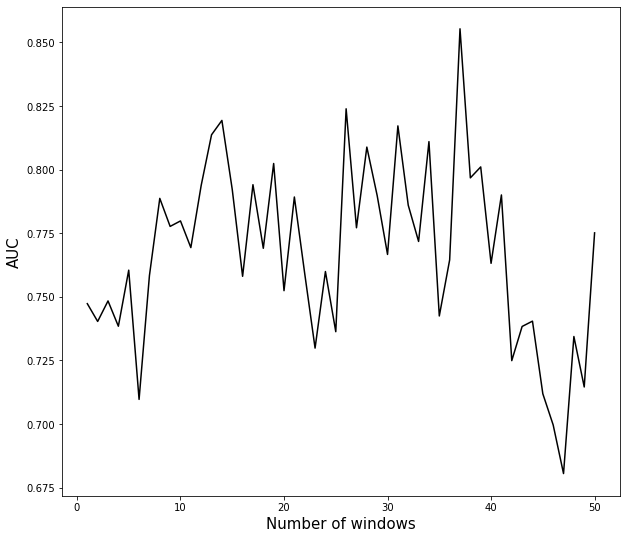

In [42]:
fig, ax = plt.subplots(figsize=(10, 9))
ax.plot(number_of_windows, AUC, color='k')
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('Number of windows', fontsize=15)

In [40]:
number_of_windows[1:51:10]

SyntaxError: invalid syntax (<ipython-input-40-97994138cacf>, line 1)

Text(0.5, 0, 'False Positive Rate')

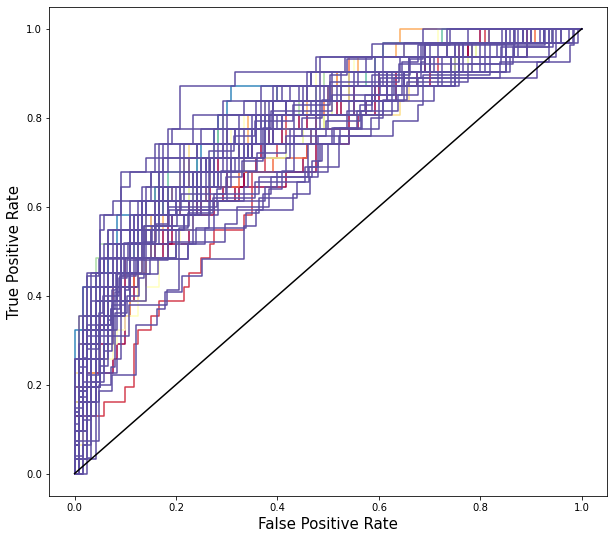

In [59]:
fig, ax = plt.subplots(figsize=(10, 9))

import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')


n = 1
for r in rocs:
    
    fpr, tpr, t = r
    ax.plot(fpr, tpr, label='n-windows={}'.format(w), color=cmap((n-5)/10))

    n += 1
ax.plot([0, 1], [0, 1], color='k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
# ax.legend(['n-windows={}'.format(n) for n in number_of_windows])
# ax.legend(['n-windows={}'.format(n) for n in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45]])

# Resampled data

In [44]:
df['label'] = df['Surge']

In [49]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [50]:
# sloped = df.groupby('rgiid').apply(get_slope)

number_of_windows = np.arange(1, 51, 1)

rocs_resampled = []
AUC_resampled=[]

for w in number_of_windows:

    sloped = df.groupby('rgiid').apply(lambda x: get_slope(x, w))

    slope_df = pd.DataFrame()

    for s in sloped.index:
        sdf = pd.DataFrame(sloped[s])
        sdf['rgiid'] = (s,)*sdf.shape[0]
        slope_df = pd.concat([slope_df, sdf])

    glacstats_df = df[['rgiid', 'Surge', 'Area', 'Slope', 'TermType', 'Name', 'bed',
       'thickness', 'surface_elevation', 'cmb', 'width_centerline', 'Runoff']].drop_duplicates()

    analysis_df = slope_df.merge(glacstats_df)
    analysis_df.dropna(subset=['thick_mean', 'bed_slope'], inplace=True)
    
    th = analysis_df.pivot_table(index='rgiid', columns='window_id', values='thick_mean')
    th.columns = ['thick_w'+str(t) for t in th.columns]

    wl = analysis_df.pivot_table(index='rgiid', columns='window_id', values='window_length')
    wl.columns = ['windowlength_w'+str(t) for t in wl.columns]

    bs = analysis_df.pivot_table(index='rgiid', columns='window_id', values='bed_slope')
    bs.columns = ['bedslope_w'+str(t) for t in bs.columns]

    ss = analysis_df.pivot_table(index='rgiid', columns='window_id', values='surf_slope')
    ss.columns = ['surfslope_w'+str(t) for t in ss.columns]
    
    wm = analysis_df.pivot_table(index='rgiid', columns='window_id', values='width_mean')
    wm.columns = ['width_w'+str(t) for t in wm.columns]
    
    cmb = analysis_df.pivot_table(index='rgiid', columns='window_id', values='CMB_mean')
    cmb.columns = ['CMB_w'+str(t) for t in cmb.columns]
    
    rs = analysis_df.pivot_table(index='rgiid', columns='window_id', values='runoff_mean')
    rs.columns = ['runoff_w'+str(t) for t in rs.columns]
    
    zmin = analysis_df.pivot_table(index='rgiid', columns='window_id', values='Z_min')
    zmin.columns = ['Zmin_w'+str(t) for t in zmin.columns]
    
    zmax = analysis_df.pivot_table(index='rgiid', columns='window_id', values='Z_max')
    zmax.columns = ['Zmax_w'+str(t) for t in zmax.columns]
    
    zmean= analysis_df.pivot_table(index='rgiid', columns='window_id', values='Z_mean')
    zmean.columns = ['Zmean_w'+str(t) for t in zmean.columns]

    # an_df = analysis_df[['rgiid', 'Name', 'surgetype', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax']].drop_duplicates().set_index('rgiid')
    an_df = analysis_df[['rgiid', 'Surge', 'Area', 'TermType']].drop_duplicates().set_index('rgiid')

    statmodel_df = an_df.join(th).join(wl).join(bs).join(ss).join(wm).join(cmb).join(rs).join(zmin).join(zmax).join(zmean).copy()
    
    columns_for_modeling = statmodel_df.columns

    x_train, x_test, y_train, y_test = train_test_split(statmodel_df[columns_for_modeling[1:]], statmodel_df[columns_for_modeling[0]], random_state=42)
    dmatrix_train = xgboost.DMatrix(x_train, label=y_train)
    dmatrix_test = xgboost.DMatrix(x_test, label=y_test)

    params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.3}

    xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

    params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.3}

    xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)
    
    predictions = xgb.predict(dmatrix_test)
    rocs_resampled.append(metrics.roc_curve(y_true=y_test, y_score=predictions))
    
    AUC_resampled.append(metrics.roc_auc_score(y_true=y_test, y_score=predictions))
    
    print('window size =', w, 'AUC =', metrics.roc_auc_score(y_true=y_test, y_score=predictions))

RGI60-07.00006 (6,) (6,)
RGI60-07.00008 (4,) (4,)
RGI60-07.00010 (4,) (4,)
RGI60-07.00024 (5,) (5,)
RGI60-07.00025 (2,) (2,)
RGI60-07.00026 (4,) (4,)
RGI60-07.00028 (4,) (4,)
RGI60-07.00029 (5,) (5,)
RGI60-07.00030 (5,) (5,)
RGI60-07.00031 (6,) (6,)
RGI60-07.00032 (5,) (5,)
RGI60-07.00035 (2,) (2,)
RGI60-07.00036 (7,) (7,)
RGI60-07.00037 (5,) (5,)
RGI60-07.00040 (5,) (5,)
RGI60-07.00041 (5,) (5,)
RGI60-07.00042 (2,) (2,)
RGI60-07.00043 (6,) (6,)
RGI60-07.00044 (4,) (4,)
RGI60-07.00045 (4,) (4,)
RGI60-07.00049 (4,) (4,)
RGI60-07.00052 (5,) (5,)
RGI60-07.00060 (6,) (6,)
RGI60-07.00061 (4,) (4,)
RGI60-07.00062 (6,) (6,)
RGI60-07.00063 (2,) (2,)
RGI60-07.00064 (5,) (5,)
RGI60-07.00065 (6,) (6,)
RGI60-07.00066 (6,) (6,)
RGI60-07.00068 (2,) (2,)
RGI60-07.00069 (5,) (5,)
RGI60-07.00070 (6,) (6,)
RGI60-07.00071 (5,) (5,)
RGI60-07.00072 (5,) (5,)
RGI60-07.00073 (5,) (5,)
RGI60-07.00074 (5,) (5,)
RGI60-07.00075 (5,) (5,)
RGI60-07.00076 (5,) (5,)
RGI60-07.00077 (4,) (4,)
RGI60-07.00094 (5,) (5,)


<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00106 (6,) (6,)
RGI60-07.00108 (6,) (6,)
RGI60-07.00111 (5,) (5,)
RGI60-07.00113 (6,) (6,)
RGI60-07.00118 (2,) (2,)
RGI60-07.00124 (6,) (6,)
RGI60-07.00126 (6,) (6,)
RGI60-07.00128 (2,) (2,)
RGI60-07.00130 (6,) (6,)
RGI60-07.00134 (5,) (5,)
RGI60-07.00135 (4,) (4,)
RGI60-07.00140 (5,) (5,)
RGI60-07.00142 (6,) (6,)
RGI60-07.00146 (4,) (4,)
RGI60-07.00147 (2,) (2,)
RGI60-07.00150 (4,) (4,)
RGI60-07.00151 (6,) (6,)
RGI60-07.00153 (4,) (4,)
RGI60-07.00154 (5,) (5,)
RGI60-07.00157 (4,) (4,)
RGI60-07.00159 (7,) (7,)
RGI60-07.00160 (5,) (5,)
RGI60-07.00161 (5,) (5,)
RGI60-07.00163 (5,) (5,)
RGI60-07.00164 (6,) (6,)
RGI60-07.00165 (6,) (6,)
RGI60-07.00166 (5,) (5,)
RGI60-07.00168 (5,) (5,)
RGI60-07.00169 (2,) (2,)
RGI60-07.00173 (6,) (6,)
RGI60-07.00176 (5,) (5,)
RGI60-07.00177 (4,) (4,)
RGI60-07.00178 (2,) (2,)
RGI60-07.00180 (4,) (4,)
RGI60-07.00184 (5,) (5,)
RGI60-07.00193 (5,) (5,)
RGI60-07.00195 (5,) (5,)
RGI60-07.00196 (5,) (5,)
RGI60-07.00197 (4,) (4,)
RGI60-07.00198 (5,) (5,)


<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00126 (8,) (8,)
RGI60-07.00128 (3,) (3,)
RGI60-07.00130 (9,) (9,)
RGI60-07.00134 (8,) (8,)
RGI60-07.00135 (7,) (7,)
RGI60-07.00140 (8,) (8,)
RGI60-07.00142 (11,) (11,)
RGI60-07.00146 (7,) (7,)
RGI60-07.00147 (3,) (3,)
RGI60-07.00150 (6,) (6,)
RGI60-07.00151 (9,) (9,)
RGI60-07.00153 (8,) (8,)
RGI60-07.00154 (9,) (9,)
RGI60-07.00157 (7,) (7,)
RGI60-07.00159 (8,) (8,)
RGI60-07.00160 (8,) (8,)
RGI60-07.00161 (8,) (8,)
RGI60-07.00163 (9,) (9,)
RGI60-07.00164 (12,) (12,)
RGI60-07.00165 (10,) (10,)
RGI60-07.00166 (9,) (9,)
RGI60-07.00168 (9,) (9,)
RGI60-07.00169 (3,) (3,)
RGI60-07.00173 (11,) (11,)
RGI60-07.00176 (9,) (9,)
RGI60-07.00177 (7,) (7,)
RGI60-07.00178 (3,) (3,)
RGI60-07.00180 (7,) (7,)
RGI60-07.00184 (8,) (8,)
RGI60-07.00193 (8,) (8,)
RGI60-07.00195 (9,) (9,)
RGI60-07.00196 (9,) (9,)
RGI60-07.00197 (7,) (7,)
RGI60-07.00198 (9,) (9,)
RGI60-07.00203 (3,) (3,)
RGI60-07.00204 (10,) (10,)
RGI60-07.00205 (8,) (8,)
RGI60-07.00208 (7,) (7,)
RGI60-07.00214 (8,) (8,)
RGI60-07.00219 

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00140 (10,) (10,)
RGI60-07.00142 (13,) (13,)
RGI60-07.00146 (7,) (7,)
RGI60-07.00147 (4,) (4,)
RGI60-07.00150 (9,) (9,)
RGI60-07.00151 (11,) (11,)
RGI60-07.00153 (10,) (10,)
RGI60-07.00154 (13,) (13,)
RGI60-07.00157 (8,) (8,)
RGI60-07.00159 (9,) (9,)
RGI60-07.00160 (12,) (12,)
RGI60-07.00161 (11,) (11,)
RGI60-07.00163 (12,) (12,)
RGI60-07.00164 (14,) (14,)
RGI60-07.00165 (13,) (13,)
RGI60-07.00166 (13,) (13,)
RGI60-07.00168 (9,) (9,)
RGI60-07.00169 (4,) (4,)
RGI60-07.00173 (12,) (12,)
RGI60-07.00176 (12,) (12,)
RGI60-07.00177 (11,) (11,)
RGI60-07.00178 (4,) (4,)
RGI60-07.00180 (11,) (11,)
RGI60-07.00184 (11,) (11,)
RGI60-07.00193 (12,) (12,)
RGI60-07.00195 (11,) (11,)
RGI60-07.00196 (12,) (12,)
RGI60-07.00197 (9,) (9,)
RGI60-07.00198 (13,) (13,)
RGI60-07.00203 (4,) (4,)
RGI60-07.00204 (10,) (10,)
RGI60-07.00205 (11,) (11,)
RGI60-07.00208 (10,) (10,)
RGI60-07.00214 (11,) (11,)
RGI60-07.00219 (9,) (9,)
RGI60-07.00220 (9,) (9,)
RGI60-07.00221 (12,) (12,)
RGI60-07.00222 (10,) (10,

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00094 (13,) (13,)
RGI60-07.00098 (16,) (16,)
RGI60-07.00102 (5,) (5,)
RGI60-07.00104 (12,) (12,)
RGI60-07.00106 (14,) (14,)
RGI60-07.00108 (14,) (14,)
RGI60-07.00111 (14,) (14,)
RGI60-07.00113 (13,) (13,)
RGI60-07.00118 (5,) (5,)
RGI60-07.00124 (12,) (12,)
RGI60-07.00126 (11,) (11,)
RGI60-07.00128 (5,) (5,)
RGI60-07.00130 (14,) (14,)
RGI60-07.00134 (11,) (11,)
RGI60-07.00135 (11,) (11,)
RGI60-07.00140 (12,) (12,)
RGI60-07.00142 (15,) (15,)
RGI60-07.00146 (10,) (10,)
RGI60-07.00147 (5,) (5,)
RGI60-07.00150 (11,) (11,)
RGI60-07.00151 (13,) (13,)
RGI60-07.00153 (12,) (12,)
RGI60-07.00154 (11,) (11,)
RGI60-07.00157 (10,) (10,)
RGI60-07.00159 (10,) (10,)
RGI60-07.00160 (15,) (15,)
RGI60-07.00161 (15,) (15,)
RGI60-07.00163 (15,) (15,)
RGI60-07.00164 (17,) (17,)
RGI60-07.00165 (14,) (14,)
RGI60-07.00166 (16,) (16,)
RGI60-07.00168 (10,) (10,)
RGI60-07.00169 (5,) (5,)
RGI60-07.00173 (16,) (16,)
RGI60-07.00176 (12,) (12,)
RGI60-07.00177 (13,) (13,)
RGI60-07.00178 (5,) (5,)
RGI60-07.0018

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00126 (14,) (14,)
RGI60-07.00128 (6,) (6,)
RGI60-07.00130 (15,) (15,)
RGI60-07.00134 (14,) (14,)
RGI60-07.00135 (14,) (14,)
RGI60-07.00140 (13,) (13,)
RGI60-07.00142 (13,) (13,)
RGI60-07.00146 (10,) (10,)
RGI60-07.00147 (6,) (6,)
RGI60-07.00150 (14,) (14,)
RGI60-07.00151 (15,) (15,)
RGI60-07.00153 (13,) (13,)
RGI60-07.00154 (13,) (13,)
RGI60-07.00157 (11,) (11,)
RGI60-07.00159 (10,) (10,)
RGI60-07.00160 (19,) (19,)
RGI60-07.00161 (17,) (17,)
RGI60-07.00163 (15,) (15,)
RGI60-07.00164 (18,) (18,)
RGI60-07.00165 (13,) (13,)
RGI60-07.00166 (16,) (16,)
RGI60-07.00168 (11,) (11,)
RGI60-07.00169 (6,) (6,)
RGI60-07.00173 (16,) (16,)
RGI60-07.00176 (16,) (16,)
RGI60-07.00177 (16,) (16,)
RGI60-07.00178 (6,) (6,)
RGI60-07.00180 (15,) (15,)
RGI60-07.00184 (15,) (15,)
RGI60-07.00193 (15,) (15,)
RGI60-07.00195 (15,) (15,)
RGI60-07.00196 (14,) (14,)
RGI60-07.00197 (11,) (11,)
RGI60-07.00198 (18,) (18,)
RGI60-07.00203 (6,) (6,)
RGI60-07.00204 (15,) (15,)
RGI60-07.00205 (12,) (12,)
RGI60-07.00

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00135 (14,) (14,)
RGI60-07.00140 (14,) (14,)
RGI60-07.00142 (17,) (17,)
RGI60-07.00146 (10,) (10,)
RGI60-07.00147 (7,) (7,)
RGI60-07.00150 (14,) (14,)
RGI60-07.00151 (16,) (16,)
RGI60-07.00153 (14,) (14,)
RGI60-07.00154 (16,) (16,)
RGI60-07.00157 (11,) (11,)
RGI60-07.00159 (10,) (10,)
RGI60-07.00160 (21,) (21,)
RGI60-07.00161 (19,) (19,)
RGI60-07.00163 (16,) (16,)
RGI60-07.00164 (18,) (18,)
RGI60-07.00165 (14,) (14,)
RGI60-07.00166 (18,) (18,)
RGI60-07.00168 (11,) (11,)
RGI60-07.00169 (7,) (7,)
RGI60-07.00173 (17,) (17,)
RGI60-07.00176 (15,) (15,)
RGI60-07.00177 (18,) (18,)
RGI60-07.00178 (7,) (7,)
RGI60-07.00180 (16,) (16,)
RGI60-07.00184 (15,) (15,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (19,) (19,)
RGI60-07.00196 (18,) (18,)
RGI60-07.00197 (12,) (12,)
RGI60-07.00198 (19,) (19,)
RGI60-07.00203 (7,) (7,)
RGI60-07.00204 (15,) (15,)
RGI60-07.00205 (14,) (14,)
RGI60-07.00208 (13,) (13,)
RGI60-07.00214 (15,) (15,)
RGI60-07.00219 (10,) (10,)
RGI60-07.00220 (14,) (14,)
RGI60-07.

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00098 (16,) (16,)
RGI60-07.00102 (8,) (8,)
RGI60-07.00104 (13,) (13,)
RGI60-07.00106 (15,) (15,)
RGI60-07.00108 (14,) (14,)
RGI60-07.00111 (13,) (13,)
RGI60-07.00113 (16,) (16,)
RGI60-07.00118 (8,) (8,)
RGI60-07.00124 (13,) (13,)
RGI60-07.00126 (15,) (15,)
RGI60-07.00128 (8,) (8,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (16,) (16,)
RGI60-07.00135 (15,) (15,)
RGI60-07.00140 (16,) (16,)
RGI60-07.00142 (16,) (16,)
RGI60-07.00146 (12,) (12,)
RGI60-07.00147 (8,) (8,)
RGI60-07.00150 (16,) (16,)
RGI60-07.00151 (17,) (17,)
RGI60-07.00153 (16,) (16,)
RGI60-07.00154 (14,) (14,)
RGI60-07.00157 (13,) (13,)
RGI60-07.00159 (10,) (10,)
RGI60-07.00160 (22,) (22,)
RGI60-07.00161 (19,) (19,)
RGI60-07.00163 (17,) (17,)
RGI60-07.00164 (19,) (19,)
RGI60-07.00165 (16,) (16,)
RGI60-07.00166 (18,) (18,)
RGI60-07.00168 (10,) (10,)
RGI60-07.00169 (8,) (8,)
RGI60-07.00173 (16,) (16,)
RGI60-07.00176 (16,) (16,)
RGI60-07.00177 (18,) (18,)
RGI60-07.00178 (8,) (8,)
RGI60-07.00180 (16,) (16,)
RGI60-07.0018

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00065 (9,) (9,)
RGI60-07.00066 (17,) (17,)
RGI60-07.00068 (8,) (8,)
RGI60-07.00069 (19,) (19,)
RGI60-07.00070 (12,) (12,)
RGI60-07.00071 (13,) (13,)
RGI60-07.00072 (12,) (12,)
RGI60-07.00073 (12,) (12,)
RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (15,) (15,)
RGI60-07.00076 (21,) (21,)
RGI60-07.00077 (14,) (14,)
RGI60-07.00094 (20,) (20,)
RGI60-07.00098 (18,) (18,)
RGI60-07.00102 (9,) (9,)
RGI60-07.00104 (13,) (13,)
RGI60-07.00106 (16,) (16,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (15,) (15,)
RGI60-07.00113 (17,) (17,)
RGI60-07.00118 (8,) (8,)
RGI60-07.00124 (14,) (14,)
RGI60-07.00126 (15,) (15,)
RGI60-07.00128 (9,) (9,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (15,) (15,)
RGI60-07.00135 (15,) (15,)
RGI60-07.00140 (15,) (15,)
RGI60-07.00142 (17,) (17,)
RGI60-07.00146 (12,) (12,)
RGI60-07.00147 (9,) (9,)
RGI60-07.00150 (19,) (19,)
RGI60-07.00151 (19,) (19,)
RGI60-07.00153 (14,) (14,)
RGI60-07.00154 (15,) (15,)
RGI60-07.00157 (13,) (13,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00094 (22,) (22,)
RGI60-07.00098 (18,) (18,)
RGI60-07.00102 (10,) (10,)
RGI60-07.00104 (14,) (14,)
RGI60-07.00106 (15,) (15,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (15,) (15,)
RGI60-07.00113 (18,) (18,)
RGI60-07.00118 (10,) (10,)
RGI60-07.00124 (13,) (13,)
RGI60-07.00126 (16,) (16,)
RGI60-07.00128 (10,) (10,)
RGI60-07.00130 (16,) (16,)
RGI60-07.00134 (18,) (18,)
RGI60-07.00135 (17,) (17,)
RGI60-07.00140 (16,) (16,)
RGI60-07.00142 (16,) (16,)
RGI60-07.00146 (13,) (13,)
RGI60-07.00147 (9,) (9,)
RGI60-07.00150 (20,) (20,)
RGI60-07.00151 (19,) (19,)
RGI60-07.00153 (15,) (15,)
RGI60-07.00154 (17,) (17,)
RGI60-07.00157 (13,) (13,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (27,) (27,)
RGI60-07.00161 (21,) (21,)
RGI60-07.00163 (17,) (17,)
RGI60-07.00164 (20,) (20,)
RGI60-07.00165 (17,) (17,)
RGI60-07.00166 (20,) (20,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (10,) (10,)
RGI60-07.00173 (16,) (16,)
RGI60-07.00176 (19,) (19,)
RGI60-07.00177 (19,) (19,)
RGI60-07.00178 (10,) (10,)
RGI

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00108 (14,) (14,)
RGI60-07.00111 (16,) (16,)
RGI60-07.00113 (18,) (18,)
RGI60-07.00118 (11,) (11,)
RGI60-07.00124 (14,) (14,)
RGI60-07.00126 (16,) (16,)
RGI60-07.00128 (11,) (11,)
RGI60-07.00130 (16,) (16,)
RGI60-07.00134 (17,) (17,)
RGI60-07.00135 (19,) (19,)
RGI60-07.00140 (16,) (16,)
RGI60-07.00142 (16,) (16,)
RGI60-07.00146 (14,) (14,)
RGI60-07.00147 (11,) (11,)
RGI60-07.00150 (20,) (20,)
RGI60-07.00151 (19,) (19,)
RGI60-07.00153 (18,) (18,)
RGI60-07.00154 (16,) (16,)
RGI60-07.00157 (14,) (14,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (24,) (24,)
RGI60-07.00161 (22,) (22,)
RGI60-07.00163 (20,) (20,)
RGI60-07.00164 (21,) (21,)
RGI60-07.00165 (16,) (16,)
RGI60-07.00166 (20,) (20,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (11,) (11,)
RGI60-07.00173 (18,) (18,)
RGI60-07.00176 (20,) (20,)
RGI60-07.00177 (23,) (23,)
RGI60-07.00178 (11,) (11,)
RGI60-07.00180 (18,) (18,)
RGI60-07.00184 (16,) (16,)
RGI60-07.00193 (17,) (17,)
RGI60-07.00195 (21,) (21,)
RGI60-07.00196 (19,) (19,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00130 (16,) (16,)
RGI60-07.00134 (17,) (17,)
RGI60-07.00135 (17,) (17,)
RGI60-07.00140 (15,) (15,)
RGI60-07.00142 (15,) (15,)
RGI60-07.00146 (14,) (14,)
RGI60-07.00147 (12,) (12,)
RGI60-07.00150 (21,) (21,)
RGI60-07.00151 (18,) (18,)
RGI60-07.00153 (18,) (18,)
RGI60-07.00154 (18,) (18,)
RGI60-07.00157 (15,) (15,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (28,) (28,)
RGI60-07.00161 (22,) (22,)
RGI60-07.00163 (16,) (16,)
RGI60-07.00164 (21,) (21,)
RGI60-07.00165 (17,) (17,)
RGI60-07.00166 (21,) (21,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (12,) (12,)
RGI60-07.00173 (17,) (17,)
RGI60-07.00176 (20,) (20,)
RGI60-07.00177 (22,) (22,)
RGI60-07.00178 (12,) (12,)
RGI60-07.00180 (18,) (18,)
RGI60-07.00184 (17,) (17,)
RGI60-07.00193 (17,) (17,)
RGI60-07.00195 (21,) (21,)
RGI60-07.00196 (21,) (21,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (24,) (24,)
RGI60-07.00203 (12,) (12,)
RGI60-07.00204 (18,) (18,)
RGI60-07.00205 (15,) (15,)
RGI60-07.00208 (13,) (13,)
RGI60-07.00214 (17,) (17,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00135 (17,) (17,)
RGI60-07.00140 (16,) (16,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (13,) (13,)
RGI60-07.00147 (13,) (13,)
RGI60-07.00150 (22,) (22,)
RGI60-07.00151 (20,) (20,)
RGI60-07.00153 (16,) (16,)
RGI60-07.00154 (17,) (17,)
RGI60-07.00157 (15,) (15,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (27,) (27,)
RGI60-07.00161 (24,) (24,)
RGI60-07.00163 (19,) (19,)
RGI60-07.00164 (22,) (22,)
RGI60-07.00165 (16,) (16,)
RGI60-07.00166 (22,) (22,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (13,) (13,)
RGI60-07.00173 (18,) (18,)
RGI60-07.00176 (20,) (20,)
RGI60-07.00177 (25,) (25,)
RGI60-07.00178 (13,) (13,)
RGI60-07.00180 (18,) (18,)
RGI60-07.00184 (17,) (17,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (23,) (23,)
RGI60-07.00196 (19,) (19,)
RGI60-07.00197 (14,) (14,)
RGI60-07.00198 (25,) (25,)
RGI60-07.00203 (13,) (13,)
RGI60-07.00204 (18,) (18,)
RGI60-07.00205 (15,) (15,)
RGI60-07.00208 (14,) (14,)
RGI60-07.00214 (17,) (17,)
RGI60-07.00219 (11,) (11,)
RGI60-07.00220 (17,) (17,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00135 (19,) (19,)
RGI60-07.00140 (16,) (16,)
RGI60-07.00142 (17,) (17,)
RGI60-07.00146 (15,) (15,)
RGI60-07.00147 (14,) (14,)
RGI60-07.00150 (19,) (19,)
RGI60-07.00151 (20,) (20,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (17,) (17,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (25,) (25,)
RGI60-07.00161 (23,) (23,)
RGI60-07.00163 (19,) (19,)
RGI60-07.00164 (22,) (22,)
RGI60-07.00165 (18,) (18,)
RGI60-07.00166 (21,) (21,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (13,) (13,)
RGI60-07.00173 (18,) (18,)
RGI60-07.00176 (20,) (20,)
RGI60-07.00177 (24,) (24,)
RGI60-07.00178 (13,) (13,)
RGI60-07.00180 (17,) (17,)
RGI60-07.00184 (18,) (18,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (21,) (21,)
RGI60-07.00196 (20,) (20,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (24,) (24,)
RGI60-07.00203 (14,) (14,)
RGI60-07.00204 (18,) (18,)
RGI60-07.00205 (15,) (15,)
RGI60-07.00208 (13,) (13,)
RGI60-07.00214 (18,) (18,)
RGI60-07.00219 (11,) (11,)
RGI60-07.00220 (15,) (15,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (15,) (15,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (19,) (19,)
RGI60-07.00135 (18,) (18,)
RGI60-07.00140 (17,) (17,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (15,) (15,)
RGI60-07.00147 (15,) (15,)
RGI60-07.00150 (20,) (20,)
RGI60-07.00151 (20,) (20,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (18,) (18,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (30,) (30,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (20,) (20,)
RGI60-07.00164 (22,) (22,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (23,) (23,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (15,) (15,)
RGI60-07.00173 (18,) (18,)
RGI60-07.00176 (20,) (20,)
RGI60-07.00177 (23,) (23,)
RGI60-07.00178 (15,) (15,)
RGI60-07.00180 (18,) (18,)
RGI60-07.00184 (17,) (17,)
RGI60-07.00193 (17,) (17,)
RGI60-07.00195 (22,) (22,)
RGI60-07.00196 (19,) (19,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (25,) (25,)
RGI60-07.00203 (15,) (15,)
RGI60-07.00204 (19,) (19,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00118 (16,) (16,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (17,) (17,)
RGI60-07.00128 (16,) (16,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (19,) (19,)
RGI60-07.00135 (19,) (19,)
RGI60-07.00140 (16,) (16,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (16,) (16,)
RGI60-07.00150 (21,) (21,)
RGI60-07.00151 (19,) (19,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (28,) (28,)
RGI60-07.00161 (24,) (24,)
RGI60-07.00163 (20,) (20,)
RGI60-07.00164 (22,) (22,)
RGI60-07.00165 (16,) (16,)
RGI60-07.00166 (21,) (21,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (16,) (16,)
RGI60-07.00173 (18,) (18,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (24,) (24,)
RGI60-07.00178 (16,) (16,)
RGI60-07.00180 (18,) (18,)
RGI60-07.00184 (18,) (18,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (21,) (21,)
RGI60-07.00196 (21,) (21,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (27,) (27,)
RGI60-07.00203 (16,) (16,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00118 (16,) (16,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (17,) (17,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (17,) (17,)
RGI60-07.00135 (18,) (18,)
RGI60-07.00140 (17,) (17,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (17,) (17,)
RGI60-07.00150 (24,) (24,)
RGI60-07.00151 (20,) (20,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (17,) (17,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (31,) (31,)
RGI60-07.00161 (24,) (24,)
RGI60-07.00163 (18,) (18,)
RGI60-07.00164 (22,) (22,)
RGI60-07.00165 (19,) (19,)
RGI60-07.00166 (23,) (23,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (16,) (16,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (20,) (20,)
RGI60-07.00177 (23,) (23,)
RGI60-07.00178 (17,) (17,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (21,) (21,)
RGI60-07.00196 (22,) (22,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (24,) (24,)
RGI60-07.00203 (17,) (17,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00111 (17,) (17,)
RGI60-07.00113 (18,) (18,)
RGI60-07.00118 (17,) (17,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (18,) (18,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (20,) (20,)
RGI60-07.00135 (20,) (20,)
RGI60-07.00140 (17,) (17,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (18,) (18,)
RGI60-07.00150 (21,) (21,)
RGI60-07.00151 (21,) (21,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (18,) (18,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (30,) (30,)
RGI60-07.00161 (24,) (24,)
RGI60-07.00163 (20,) (20,)
RGI60-07.00164 (21,) (21,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (21,) (21,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (18,) (18,)
RGI60-07.00173 (18,) (18,)
RGI60-07.00176 (20,) (20,)
RGI60-07.00177 (26,) (26,)
RGI60-07.00178 (18,) (18,)
RGI60-07.00180 (18,) (18,)
RGI60-07.00184 (18,) (18,)
RGI60-07.00193 (17,) (17,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (22,) (22,)
RGI60-07.00197 (15,) (15,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00044 (12,) (12,)
RGI60-07.00045 (15,) (15,)
RGI60-07.00049 (13,) (13,)
RGI60-07.00052 (9,) (9,)
RGI60-07.00060 (20,) (20,)
RGI60-07.00061 (28,) (28,)
RGI60-07.00062 (30,) (30,)
RGI60-07.00063 (19,) (19,)
RGI60-07.00064 (14,) (14,)
RGI60-07.00065 (9,) (9,)
RGI60-07.00066 (20,) (20,)
RGI60-07.00068 (19,) (19,)
RGI60-07.00069 (20,) (20,)
RGI60-07.00070 (12,) (12,)
RGI60-07.00071 (15,) (15,)
RGI60-07.00072 (14,) (14,)
RGI60-07.00073 (15,) (15,)
RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (19,) (19,)
RGI60-07.00076 (22,) (22,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (23,) (23,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (18,) (18,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (19,) (19,)
RGI60-07.00118 (19,) (19,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (19,) (19,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (20,) (20,)
RGI60-07.00140 (18,) (18,)
RGI60-0

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00063 (20,) (20,)
RGI60-07.00064 (14,) (14,)
RGI60-07.00065 (9,) (9,)
RGI60-07.00066 (20,) (20,)
RGI60-07.00068 (20,) (20,)
RGI60-07.00069 (20,) (20,)
RGI60-07.00070 (12,) (12,)
RGI60-07.00071 (15,) (15,)
RGI60-07.00072 (14,) (14,)
RGI60-07.00073 (15,) (15,)
RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (19,) (19,)
RGI60-07.00076 (23,) (23,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (22,) (22,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (20,) (20,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (19,) (19,)
RGI60-07.00118 (20,) (20,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (20,) (20,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (20,) (20,)
RGI60-07.00150 (21,) (21,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00064 (14,) (14,)
RGI60-07.00065 (9,) (9,)
RGI60-07.00066 (20,) (20,)
RGI60-07.00068 (21,) (21,)
RGI60-07.00069 (20,) (20,)
RGI60-07.00070 (12,) (12,)
RGI60-07.00071 (15,) (15,)
RGI60-07.00072 (14,) (14,)
RGI60-07.00073 (15,) (15,)
RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (20,) (20,)
RGI60-07.00076 (23,) (23,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (23,) (23,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (21,) (21,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (19,) (19,)
RGI60-07.00118 (21,) (21,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (21,) (21,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (20,) (20,)
RGI60-07.00150 (24,) (24,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00063 (22,) (22,)
RGI60-07.00064 (14,) (14,)
RGI60-07.00065 (9,) (9,)
RGI60-07.00066 (20,) (20,)
RGI60-07.00068 (22,) (22,)
RGI60-07.00069 (21,) (21,)
RGI60-07.00070 (12,) (12,)
RGI60-07.00071 (15,) (15,)
RGI60-07.00072 (14,) (14,)
RGI60-07.00073 (15,) (15,)
RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (20,) (20,)
RGI60-07.00076 (23,) (23,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (25,) (25,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (22,) (22,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (22,) (22,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (22,) (22,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (22,) (22,)
RGI60-07.00150 (23,) (23,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00063 (22,) (22,)
RGI60-07.00064 (14,) (14,)
RGI60-07.00065 (9,) (9,)
RGI60-07.00066 (20,) (20,)
RGI60-07.00068 (23,) (23,)
RGI60-07.00069 (21,) (21,)
RGI60-07.00070 (12,) (12,)
RGI60-07.00071 (15,) (15,)
RGI60-07.00072 (14,) (14,)
RGI60-07.00073 (15,) (15,)
RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (20,) (20,)
RGI60-07.00076 (23,) (23,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (24,) (24,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (23,) (23,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (23,) (23,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (23,) (23,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (23,) (23,)
RGI60-07.00150 (23,) (23,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00065 (9,) (9,)
RGI60-07.00066 (20,) (20,)
RGI60-07.00068 (24,) (24,)
RGI60-07.00069 (21,) (21,)
RGI60-07.00070 (12,) (12,)
RGI60-07.00071 (15,) (15,)
RGI60-07.00072 (14,) (14,)
RGI60-07.00073 (15,) (15,)
RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (20,) (20,)
RGI60-07.00076 (23,) (23,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (25,) (25,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (24,) (24,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (24,) (24,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (23,) (23,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (24,) (24,)
RGI60-07.00150 (24,) (24,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (25,) (25,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (25,) (25,)
RGI60-07.00150 (23,) (23,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (33,) (33,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (25,) (25,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (25,) (25,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
RGI60-07.00203 (25,) (25,)
RGI60-07.00204 (20,) (20,)
RGI60-07.00205 (15,) (15,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (26,) (26,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (32,) (32,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (26,) (26,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (27,) (27,)
RGI60-07.00178 (26,) (26,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (27,) (27,)
RGI60-07.00203 (26,) (26,)
RGI60-07.00204 (20,) (20,)
RGI60-07.00205 (15,) (15,)
RGI60-07.00208 (14,) (14,)
RGI60-07.00214 (18,) (18,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (20,) (20,)
RGI60-07.00076 (23,) (23,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (26,) (26,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (27,) (27,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (27,) (27,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (26,) (26,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (27,) (27,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (32,) (32,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (26,) (26,)
RGI

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00118 (28,) (28,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (28,) (28,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (27,) (27,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (31,) (31,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (28,) (28,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (27,) (27,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
RGI60-07.00203 (28,) (28,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00075 (20,) (20,)
RGI60-07.00076 (23,) (23,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (26,) (26,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (29,) (29,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (29,) (29,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (29,) (29,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (29,) (29,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (35,) (35,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (29,) (29,)
RGI60-07.00173 (19,) (19,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00070 (12,) (12,)
RGI60-07.00071 (15,) (15,)
RGI60-07.00072 (14,) (14,)
RGI60-07.00073 (15,) (15,)
RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (20,) (20,)
RGI60-07.00076 (23,) (23,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (26,) (26,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (30,) (30,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (30,) (30,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (29,) (29,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (29,) (29,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (34,) (34,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (31,) (31,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (31,) (31,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (31,) (31,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (34,) (34,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (31,) (31,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (30,) (30,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00128 (32,) (32,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (32,) (32,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (34,) (34,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (32,) (32,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (31,) (31,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
RGI60-07.00203 (31,) (31,)
RGI60-07.00204 (20,) (20,)
RGI60-07.00205 (15,) (15,)
RGI60-07.00208 (14,) (14,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (33,) (33,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (35,) (35,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (32,) (32,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (33,) (33,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
RGI60-07.00203 (32,) (32,)
RGI60-07.00204 (20,) (20,)
RGI60-07.00205 (15,) (15,)
RGI60-07.00208 (14,) (14,)
RGI60-07.00214 (18,) (18,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (33,) (33,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (34,) (34,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (34,) (34,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (34,) (34,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (33,) (33,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (34,) (34,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (34,) (34,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (35,) (35,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (34,) (34,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (35,) (35,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (35,) (35,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (35,) (35,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (36,) (36,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (35,) (35,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (35,) (35,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (35,) (35,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
RGI60-07.00203 (35,) (35,)
RGI60-07.00204 (20,) (20,)
RGI60-07.00205 (15,) (15,)
RGI60-07.00208 (14,) (14,)
RGI60-07.00214 (18,) (18,)
RGI60-07.00219 (11,) (11,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (36,) (36,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (35,) (35,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (36,) (36,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (37,) (37,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
RGI60-07.00203 (36,) (36,)
RGI60-07.00204 (20,) (20,)
RGI60-07.00205 (15,) (15,)
RGI60-07.00208 (14,) (14,)
RGI60-07.00214 (18,) (18,)
RGI60-07.00219 (11,) (11,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (37,) (37,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (38,) (38,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (38,) (38,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (38,) (38,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (35,) (35,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (38,) (38,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (38,) (38,)
RGI60-07.00180 (19,) (19,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (38,) (38,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (38,) (38,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (35,) (35,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (38,) (38,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (39,) (39,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
RGI60-07.00203 (38,) (38,)
RGI60-07.00204 (20,) (20,)
RGI60-07.00205 (15,) (15,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00063 (40,) (40,)
RGI60-07.00064 (14,) (14,)
RGI60-07.00065 (9,) (9,)
RGI60-07.00066 (20,) (20,)
RGI60-07.00068 (40,) (40,)
RGI60-07.00069 (21,) (21,)
RGI60-07.00070 (12,) (12,)
RGI60-07.00071 (15,) (15,)
RGI60-07.00072 (14,) (14,)
RGI60-07.00073 (15,) (15,)
RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (20,) (20,)
RGI60-07.00076 (23,) (23,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (26,) (26,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (40,) (40,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (40,) (40,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (40,) (40,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (40,) (40,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (40,) (40,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (35,) (35,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (41,) (41,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (40,) (40,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
RGI60-07.00203 (41,) (41,)
RGI60-07.00204 (20,) (20,)
RGI60-07.00205 (15,) (15,)
RGI60-07.00208 (14,) (14,)
RGI60-07.00214 (18,) (18,)
RGI60-07.00219 (11,) (11,)
R

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00068 (41,) (41,)
RGI60-07.00069 (21,) (21,)
RGI60-07.00070 (12,) (12,)
RGI60-07.00071 (15,) (15,)
RGI60-07.00072 (14,) (14,)
RGI60-07.00073 (15,) (15,)
RGI60-07.00074 (9,) (9,)
RGI60-07.00075 (20,) (20,)
RGI60-07.00076 (23,) (23,)
RGI60-07.00077 (17,) (17,)
RGI60-07.00094 (26,) (26,)
RGI60-07.00098 (20,) (20,)
RGI60-07.00102 (41,) (41,)
RGI60-07.00104 (15,) (15,)
RGI60-07.00106 (17,) (17,)
RGI60-07.00108 (15,) (15,)
RGI60-07.00111 (18,) (18,)
RGI60-07.00113 (21,) (21,)
RGI60-07.00118 (41,) (41,)
RGI60-07.00124 (15,) (15,)
RGI60-07.00126 (18,) (18,)
RGI60-07.00128 (41,) (41,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (42,) (42,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (35,) (35,)
RGI60-07.00161 (25,) (25,)
RGI

<ipython-input-5-8c700207345d>:27: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-5-8c700207345d>:28: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00128 (43,) (43,)
RGI60-07.00130 (17,) (17,)
RGI60-07.00134 (21,) (21,)
RGI60-07.00135 (21,) (21,)
RGI60-07.00140 (18,) (18,)
RGI60-07.00142 (18,) (18,)
RGI60-07.00146 (16,) (16,)
RGI60-07.00147 (43,) (43,)
RGI60-07.00150 (25,) (25,)
RGI60-07.00151 (22,) (22,)
RGI60-07.00153 (19,) (19,)
RGI60-07.00154 (19,) (19,)
RGI60-07.00157 (16,) (16,)
RGI60-07.00159 (11,) (11,)
RGI60-07.00160 (35,) (35,)
RGI60-07.00161 (25,) (25,)
RGI60-07.00163 (21,) (21,)
RGI60-07.00164 (23,) (23,)
RGI60-07.00165 (20,) (20,)
RGI60-07.00166 (24,) (24,)
RGI60-07.00168 (12,) (12,)
RGI60-07.00169 (42,) (42,)
RGI60-07.00173 (19,) (19,)
RGI60-07.00176 (21,) (21,)
RGI60-07.00177 (28,) (28,)
RGI60-07.00178 (43,) (43,)
RGI60-07.00180 (19,) (19,)
RGI60-07.00184 (19,) (19,)
RGI60-07.00193 (18,) (18,)
RGI60-07.00195 (24,) (24,)
RGI60-07.00196 (23,) (23,)
RGI60-07.00197 (15,) (15,)
RGI60-07.00198 (28,) (28,)
RGI60-07.00203 (43,) (43,)
RGI60-07.00204 (20,) (20,)
RGI60-07.00205 (15,) (15,)
RGI60-07.00208 (14,) (14,)
R

/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

Text(0.5, 0, 'Number of windows')

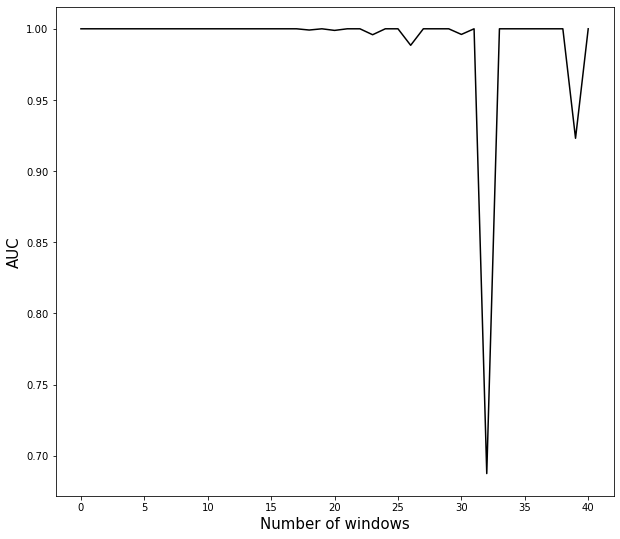

In [58]:
fig, ax = plt.subplots(figsize=(10, 9))
# ax.plot(number_of_windows, AUC, color='k')
ax.plot(AUC_resampled, color='k')
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('Number of windows', fontsize=15)